In [17]:
# Import necessary libraries
import os
import cv2
import numpy as np
from PIL import Image, ImageFilter
from skimage import filters
from skimage.io import imread
from skimage.filters import gabor_kernel
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [18]:
def preprocess_image(image, dir):
    # Median filter to remove noise
    img = cv2.medianBlur(image, 3)
    cv2.imwrite(os.path.join(dir, 'median_filtered.png'), img)

    # Otsu's thresholding for binarization and segmentation
    img = imread(os.path.join(dir, 'median_filtered.png'), as_gray=True)
    threshold = filters.threshold_otsu(img)
    binary = img > threshold
    img = Image.fromarray(binary) # Convert back to uint8 for OpenCV
    img.save(os.path.join(dir, 'binary.png'))

    # Remove horizontal lines
    img = cv2.imread(os.path.join(dir, 'binary.png'), cv2.IMREAD_GRAYSCALE)
    kernel = np.ones((1, 10), np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=1)
    cv2.imwrite(os.path.join(dir, 'horizontal_lines_removed.png'), img)

    # Morphologic opening (erosion followed by dilation) to smooth the edges
    kernel = np.ones((3, 1), np.uint8)
    erosion = cv2.erode(img, kernel, iterations=1)
    dilation = cv2.dilate(erosion, kernel, iterations=1)
    cv2.imwrite(os.path.join(dir, 'morphologic_opening.png'), dilation)

In [19]:
def get_bounding_box(image, dir):
    # Threshold the image to create a binary image
    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Apply morphological dilation to connect disconnected components
    kernel = np.ones((3, 3), np.uint8)
    dilated_image = cv2.dilate(binary_image, kernel, iterations=20)

    # Find contours of connected components
    contours, _ = cv2.findContours(dilated_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize variables to store the bounding box and bottom line feature
    max_area = 0
    max_contour = None

    # Loop through contours to find the contour with maximum area
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            max_contour = contour

    # Get the bounding box of the maximum area contour
    x, y, w, h = cv2.boundingRect(max_contour)
    cv2.imwrite(os.path.join(dir, 'bounding_box.png'), cv2.rectangle(image.copy(), (x, y), (x+w, y+h), (0, 255, 0), 2))

    return (x, y, x+w, y+h)

In [20]:
def segement_words(image, dir):
    
    x1, y1, x2, y2 = get_bounding_box(image, dir)
    x, y, w, h = x1, y1, x2 - x1, y2 - y1
    boxes = [(x, y, w, h)]

    # Calculate the average width of the bounding boxes
    widths = [box[2] for box in boxes]
    avg_width = sum(widths) / len(widths)

    # Group the bounding boxes into words
    words = []
    current_word = []
    for x, y, w, h in boxes:
        if not current_word or (y == current_word[-1][1] and x - current_word[-1][0] < avg_width // 2) or (y != current_word[-1][1] and (x, y, x+w, y+h) in [box[:4] for box in current_word]):
            current_word.append((x, y, x+w, y+h))
        else:
            words.append(current_word)
            current_word = [(x, y, x+w, y+h)]
    if current_word:
        words.append(current_word)
    
    # Save the segmented words with their bounding boxes
    # img = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    # for word in words:
    #     for x, y, x2, y2 in word:
    #         cv2.rectangle(img, (x, y), (x2, y2), (0, 0, 255), 2)
    #         cv2.imwrite(os.path.join(dir, '_segmented_words.png'), img)

    return words

In [21]:
def calculate_average_dimensions(words):
    widths = []
    heights = []
    areas = []
    
    for word in words:
        for x1, y1, x2, y2 in word:
            width = x2 - x1
            height = y2 - y1
            area = width * height
            
            widths.append(width)
            heights.append(height)
            areas.append(area)
    
    avg_width = sum(widths) / len(widths)
    avg_height = sum(heights) / len(heights)
    avg_area = sum(areas) / len(areas)
    
    return avg_width, avg_height, avg_area

In [22]:
def calculate_deviation(words):
    avg_width, avg_height, avg_area = calculate_average_dimensions(words)
    for word in words:
        for i, (x1, y1, x2, y2) in enumerate(word):
            width = x2 - x1
            height = y2 - y1
            area = width * height
            
            width_deviation = abs(width - avg_width)
            height_deviation = abs(height - avg_height)
            area_deviation = abs(area - avg_area)
            
            # Store deviations as features for each bounding box
            word[i] = (x1, y1, x2, y2, width_deviation, height_deviation, area_deviation)

    return height_deviation, width_deviation, area_deviation

In [23]:
def calculate_density(image):
    # Density
    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    density = np.count_nonzero(binary_image) / (binary_image.shape[0] * binary_image.shape[1])
    return density

In [24]:
def vertical_projection_variance(image, dir):
    # Compute the vertical projection
    vertical_projection = np.sum(image, axis=0)

    # Calculate the variance of the vertical coordinates
    vertical_coordinates = np.arange(image.shape[0])
    variance = np.var(vertical_coordinates)

    # Plot the binary image with vertical projection below
    plt.figure(figsize=(10, 12))
    
    # Plot the binary image
    plt.subplot(2, 1, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Binary Image')
    plt.axis('off')

    # Plot the vertical projection profile
    plt.subplot(2, 1, 2)
    plt.plot(np.arange(len(vertical_projection)), vertical_projection)
    plt.title('Vertical Projection Profile')
    plt.xlabel('Vertical Coordinate')
    plt.ylabel('Intensity')
    plt.gca().invert_yaxis()  # Invert y-axis to match image orientation
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(dir, 'vertical_projection.png'))

    return variance

In [25]:
def horizontal_projection_variance(image, dir):
    # Compute the horizontal projection
    horizontal_projection = np.sum(image, axis=1)

    # Calculate the variance of the horizontal coordinates
    horizontal_coordinates = np.arange(image.shape[1])
    variance = np.var(horizontal_coordinates)

    # Plot the binary image with horizontal projection beside
    plt.figure(figsize=(14, 6))

    # Plot the binary image
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Binary Image')
    plt.axis('off')

    # Plot the horizontal projection profile
    plt.subplot(1, 3, 2)
    plt.plot(horizontal_projection, np.arange(len(horizontal_projection)))
    plt.title('Horizontal Projection Profile')
    plt.xlabel('Intensity')
    plt.ylabel('Horizontal Coordinate')
    plt.gca().invert_yaxis()  # Invert y-axis to match image orientation
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(os.path.join(dir, 'horizontal_projection.png'))

    return variance

In [26]:
def calculate_pixel_distribution(image, dir):
    x1, y1, x2, y2 = get_bounding_box(image, dir)
    # Find the coordinates of the first and last black pixels in the y direction
    upper_y = y1 # 0
    lower_y = y2 # 248

    # Find the coordinates of the first and last black pixels in the y direction
    for y in range(y1, y2):
        if np.any(image[y, x1:x2]):
            upper_y = y
            break
    for y in range(y2 - 1, y1 - 1, -1):
        if np.any(image[y, x1:x2]):
            lower_y = y
            break

    print("Upper y:", upper_y)
    print("Lower y:", lower_y)

    # Convert binary image to color image
    binary_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Draw a red line in the middle of the bounding box
    cv2.line(binary_image, (x1, (upper_y + lower_y) // 2), (x2, (upper_y + lower_y) // 2), (0, 0, 255), 2)

    # Draw 2 green lines at the start and end of the word
    cv2.line(binary_image, (x1, upper_y+20), (x2, upper_y+20), (0, 255, 0), 2)
    cv2.line(binary_image, (x1, lower_y-20), (x2, lower_y-20), (0, 255, 0), 2)

    # Save the image
    cv2.imwrite(os.path.join(dir, 'pixel_distribution.png'), binary_image)

    # Calculate the density of black pixels for the upper and lower parts
    upper_box = binary_image[upper_y:lower_y//2, x1:x2]  # Adjusting the upper bound
    lower_box = binary_image[lower_y//2:y2, x1:x2]       # Adjusting the lower bound

    density_upper = np.count_nonzero(upper_box) / (upper_box.shape[0] * upper_box.shape[1])
    density_lower = np.count_nonzero(lower_box) / (lower_box.shape[0] * lower_box.shape[1])
    
    # Compute the module of the difference between the densities
    pixel_distribution_difference = abs(density_upper - density_lower)
    
    return pixel_distribution_difference

In [27]:
def compute_bottom_line_feature(image, dir):
    
    # Get the bounding box of the image
    x1, y1, x2, y2 = get_bounding_box(image, dir)
    x, y, w, h = x1 + 15, y1 + 15, x2 - x1 - 30, y2 - y1 - 30

    # Calculate the bottom line feature
    bottom_line_pixels = 0
    for i in range(w):
        if image[y + h - 1, x + i] == 0:  # Assuming white color represents the text
            bottom_line_pixels += 1

    # Calculate the ratio of bottom line pixels to the width of the bounding box
    bottom_line_ratio = bottom_line_pixels / w

    # Draw the bounding box on the original image
    image_with_bbox = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    cv2.rectangle(image_with_bbox, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.imwrite(os.path.join(dir, 'bounding_box_with_bottom_line.png'), image_with_bbox)
    
    return bottom_line_ratio

In [28]:
def compute_black_pixels_of_each_line(image, dir):

    # Get the bounding box of the image    
    x1, y1, x2, y2 = get_bounding_box(image, dir)
    x, y, w, h = x1, y1, x2 - x1, y2 - y1

    # Divide the bounding box vertically into lines
    line_features = []

    for i in range(h):
        line_y = y + i
        line_roi = image[line_y, x:x + w]

        # Count black pixels in the line
        black_pixels = np.sum(line_roi == 0)

        # Calculate ratio of black pixels to BB width for the line
        line_feature = black_pixels / w
        line_features.append(line_feature)

    # Sum up the ratios as the feature value
    black_pixels_feature = sum(line_features)

    return black_pixels_feature

In [29]:
def compute_vertical_edges_feature(image, dir):
    # Define the Prewitt filter masks for detecting vertical edges
    vertical_mask1 = np.array([[1, 0, -1],
                               [1, 0, -1],
                               [1, 0, -1],
                               [1, 0, -1],
                               [1, 0, -1],
                               [1, 0, -1],
                               [1, 0, -1]])

    vertical_mask2 = np.array([[-1, 0, 1],
                               [-1, 0, 1],
                               [-1, 0, 1],
                               [-1, 0, 1],
                               [-1, 0, 1],
                               [-1, 0, 1],
                               [-1, 0, 1]])

    # Apply the vertical Prewitt filter masks
    vertical_edges1 = cv2.filter2D(image, -1, vertical_mask1)
    vertical_edges2 = cv2.filter2D(image, -1, vertical_mask2)

    # Combine the results of both filters
    combined_edges = cv2.addWeighted(vertical_edges1, 0.5, vertical_edges2, 0.5, 0)
    # Threshold the filtered image to create a binary image
    _, binary_image = cv2.threshold(combined_edges, 0, 255, cv2.THRESH_BINARY)

    # Dilate the binary image to ensure that the vertical edges are connected
    kernel = np.ones((3, 3), np.uint8)
    dilated_image = cv2.dilate(binary_image, kernel, iterations=1)

    # Find contours of connected components
    contours, _ = cv2.findContours(dilated_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize variable to store the sum of lengths of detected vertical character contours
    total_length = 0

    # Draw purple lines only around the detected vertical edges
    result_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for contour in contours:
        for point in contour[:, 0]:
            x, y = point
            # Check if the pixel is part of a vertical edge (non-white)
            if binary_image[y, x] == 0:  # If pixel is black in the binary image
                cv2.line(result_image, (x-1, y), (x-1, y), (128, 0, 128), thickness=1)  # Purple line on left side
                cv2.line(result_image, (x+1, y), (x+1, y), (128, 0, 128), thickness=1)  # Purple line on right side

        # Compute the length of the contour
        length = cv2.arcLength(contour, closed=False)
        total_length += length

    # Calculate the bounding box area
    bounding_box_area = image.shape[0] * image.shape[1]

    # Calculate the proposed feature value
    vertical_edges_feature = total_length / bounding_box_area

    cv2.imwrite(os.path.join(dir, 'vertical_edges.png'), result_image)

    return vertical_edges_feature

In [30]:
def compute_major_vertical_edge_feature(image, dir):
    # Detect vertical edges using the same Prewitt filter
    vertical_mask = np.array([[1, 0, -1],
                              [1, 0, -1],
                              [1, 0, -1],
                              [1, 0, -1],
                              [1, 0, -1],
                              [1, 0, -1],
                              [1, 0, -1]])
    vertical_edges = cv2.filter2D(image, -1, vertical_mask)

    # Threshold the vertical edges to create a binary image
    _, binary_image = cv2.threshold(vertical_edges, 0, 255, cv2.THRESH_BINARY)

    # Find contours of connected components
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize variables
    max_edge_length = 0

    # Find the longest vertical edge
    for contour in contours:
        # Compute the length of the contour
        length = cv2.arcLength(contour, closed=False)
        if length > max_edge_length:
            max_edge_length = length
            major_vertical_edge = contour

    # Draw major vertical edge on the image
    result_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(result_image, [major_vertical_edge], -1, (128, 0, 128), 2)

    # Save the image with the major vertical edge
    cv2.imwrite(os.path.join(dir, 'major_vertical_edges.png'), result_image)

    # Get the height of the bounding box
    bounding_box_height = image.shape[0]

    # Calculate the feature value
    major_vertical_edge_feature = max_edge_length / bounding_box_height

    return major_vertical_edge_feature

In [31]:
def main():
    input_dir = "../data/Gujarati"
    output_dir = "../data/output"
    
    # Create the csv file
    with open('features.csv', 'w') as f:
        f.write('Filename,Height Deviation,Width Deviation,Area Deviation,Density,Vertical Variance,Horizontal Variance,Pixel Distribution Difference,Bottom Line Ratio,Black Pixels Feature,Vertical Edges Feature,Major Vertical Edge Feature\n')

    for filename in os.listdir(input_dir):
        if filename.endswith(".jpg"):
            img_path = os.path.join(input_dir, filename)
            img_name = os.path.splitext(filename)[0]
            img_output_dir = os.path.join(output_dir, img_name)

            os.makedirs(img_output_dir, exist_ok=True)

            img = cv2.imread(img_path)
            
            preprocess_image(img, img_output_dir)

            img = cv2.imread(os.path.join(img_output_dir, 'morphologic_opening.png'), cv2.IMREAD_GRAYSCALE)

            words = segement_words(img, img_output_dir)

            height_deviation, width_deviation, area_deviation = calculate_deviation(words)
            print("Height Deviation:", height_deviation)
            print("Width Deviation:", width_deviation)
            print("Area Deviation:", area_deviation)

            density = calculate_density(img)
            print("Density:", density)

            vertical_variance = vertical_projection_variance(img, img_output_dir)
            print("Vertical Variance:", vertical_variance)

            horizontal_variance = horizontal_projection_variance(img, img_output_dir)
            print("Horizontal Variance:", horizontal_variance)

            pixel_distribution_difference = calculate_pixel_distribution(img, img_output_dir)
            print("Pixel Distribution Difference:", pixel_distribution_difference)

            bottom_line_ratio = compute_bottom_line_feature(img, img_output_dir)
            print("Bottom Line Ratio:", bottom_line_ratio)

            black_pixels_feature = compute_black_pixels_of_each_line(img, img_output_dir)
            print("Black Pixels Feature:", black_pixels_feature)

            vertical_edges_feature = compute_vertical_edges_feature(img, img_output_dir)
            print("Vertical Edges Feature:", vertical_edges_feature)

            major_vertical_edge_feature = compute_major_vertical_edge_feature(img, img_output_dir)
            print("Major Vertical Edge Feature:", major_vertical_edge_feature)

            # Add the data into csv
            with open('features.csv', 'a') as f:
                f.write(f'{filename},{height_deviation},{width_deviation},{area_deviation},{density},{vertical_variance},{horizontal_variance},{pixel_distribution_difference},{bottom_line_ratio},{black_pixels_feature},{vertical_edges_feature},{major_vertical_edge_feature}\n')

Height Deviation: 0.0
Width Deviation: 0.0
Area Deviation: 0.0
Density: 0.09104713313896988
Vertical Variance: 7202.916666666667
Horizontal Variance: 94341.25
Upper y: 53
Lower y: 264
Pixel Distribution Difference: 0.2078890007662837
Bottom Line Ratio: 0.0
Black Pixels Feature: 31.436430317848394
Vertical Edges Feature: 0.02551751797031328
Major Vertical Edge Feature: 0.8878380437286533
Height Deviation: 0.0
Width Deviation: 0.0
Area Deviation: 0.0
Density: 0.06044690928917058
Vertical Variance: 7105.25
Horizontal Variance: 53867.916666666664
Upper y: 31
Lower y: 211
Pixel Distribution Difference: 0.22263686659224824
Bottom Line Ratio: 0.0
Black Pixels Feature: 24.346236559139783
Vertical Edges Feature: 0.019405568313445896
Major Vertical Edge Feature: 0.7763891252752853
Height Deviation: 0.0
Width Deviation: 0.0
Area Deviation: 0.0
Density: 0.07895267409508193
Vertical Variance: 7056.666666666667
Horizontal Variance: 49024.0
Upper y: 49
Lower y: 219
Pixel Distribution Difference: 0.17

/tmp/ipykernel_45726/1564316163.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 12))


Vertical Variance: 7105.25
Horizontal Variance: 66305.25
Upper y: 45
Lower y: 226
Pixel Distribution Difference: 0.11030627126883807
Bottom Line Ratio: 0.0
Black Pixels Feature: 27.066115702479344
Vertical Edges Feature: 0.023783457667592982
Major Vertical Edge Feature: 0.9778563441479042
Height Deviation: 0.0
Width Deviation: 0.0
Area Deviation: 0.0
Density: 0.07828429111705562
Vertical Variance: 7154.0
Horizontal Variance: 71302.0
Upper y: 49
Lower y: 263
Pixel Distribution Difference: 0.03036309337732046
Bottom Line Ratio: 0.0
Black Pixels Feature: 31.367875647668406
Vertical Edges Feature: 0.025235604410318416
Major Vertical Edge Feature: 0.835089553338269
Height Deviation: 0.0
Width Deviation: 0.0
Area Deviation: 0.0
Density: 0.09441178310088186
Vertical Variance: 7252.0
Horizontal Variance: 97921.25
Upper y: 0
Lower y: 215
Pixel Distribution Difference: 0.320362064530626
Bottom Line Ratio: 0.0
Black Pixels Feature: 34.1735632183908
Vertical Edges Feature: 0.028358515047864505
Maj

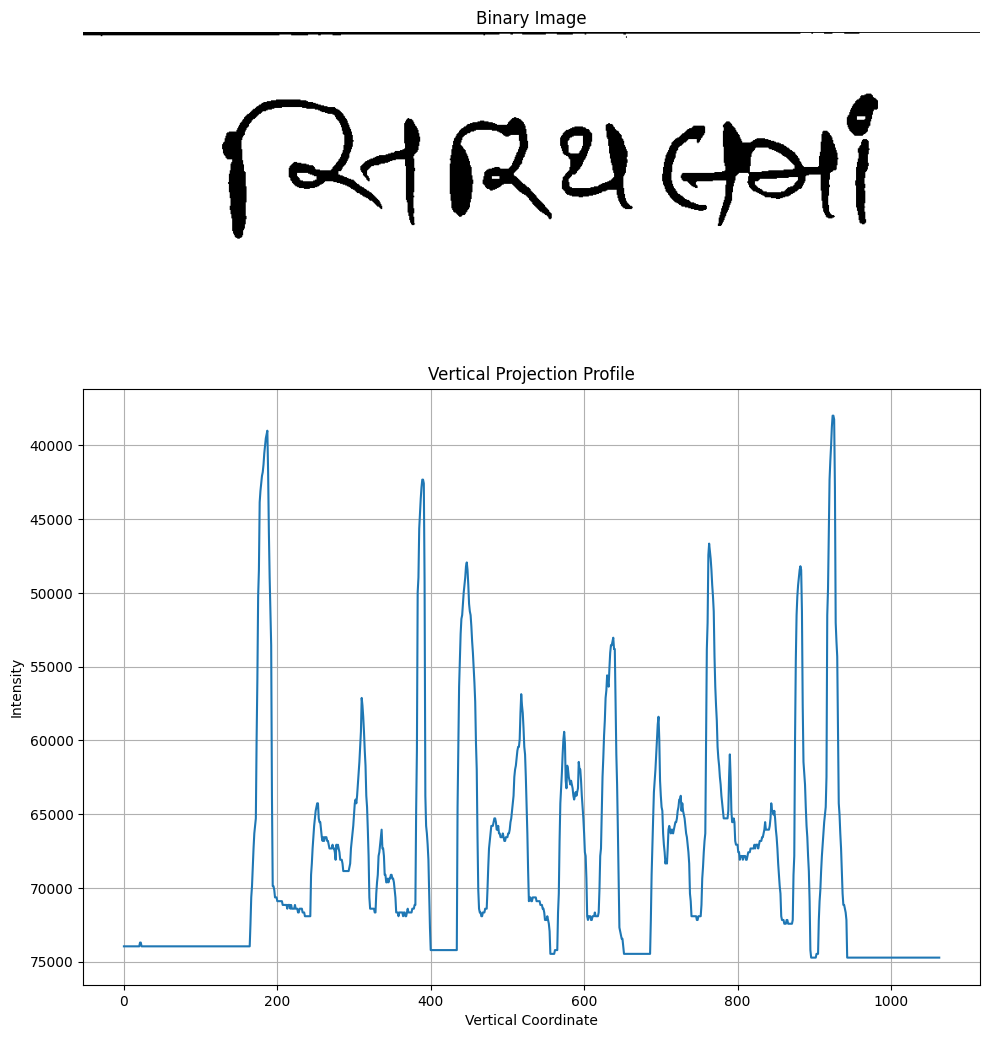

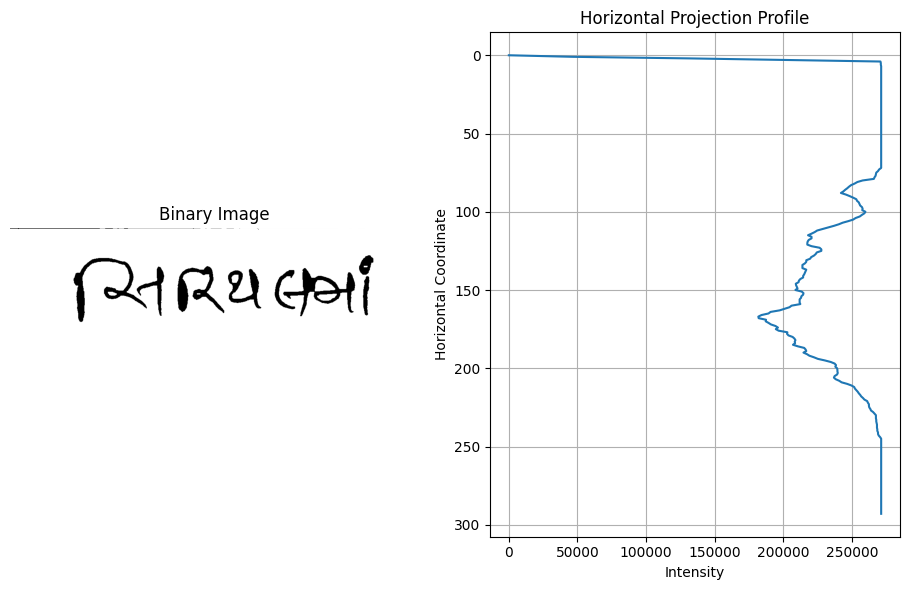

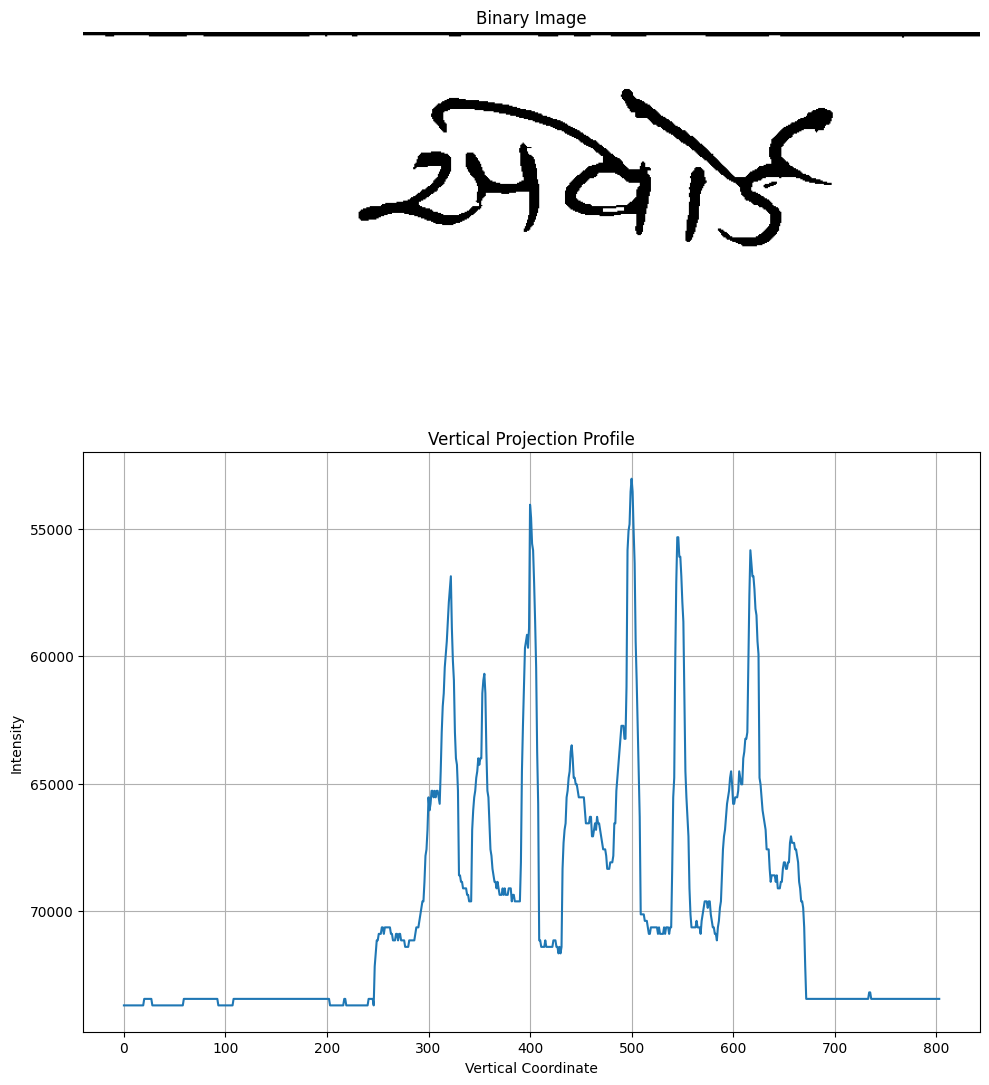

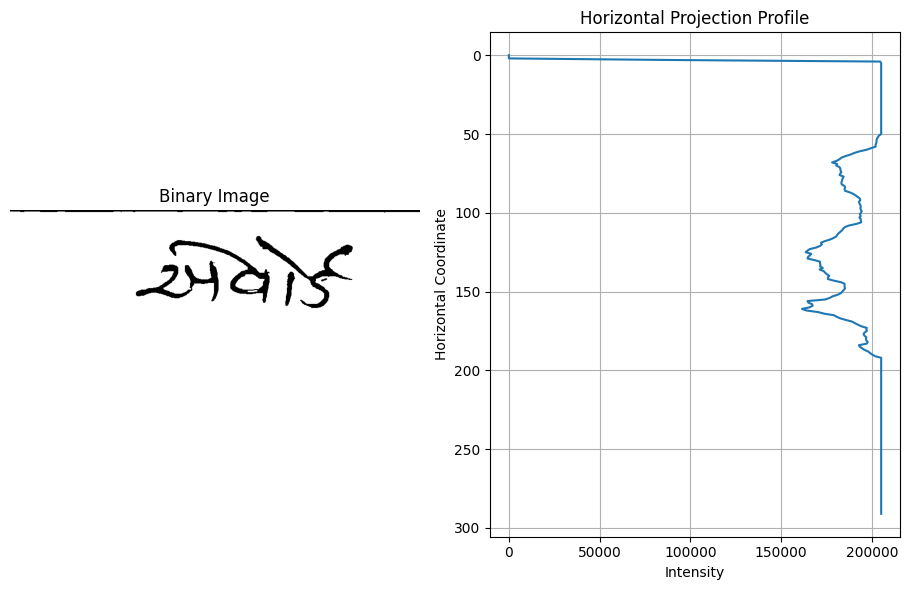

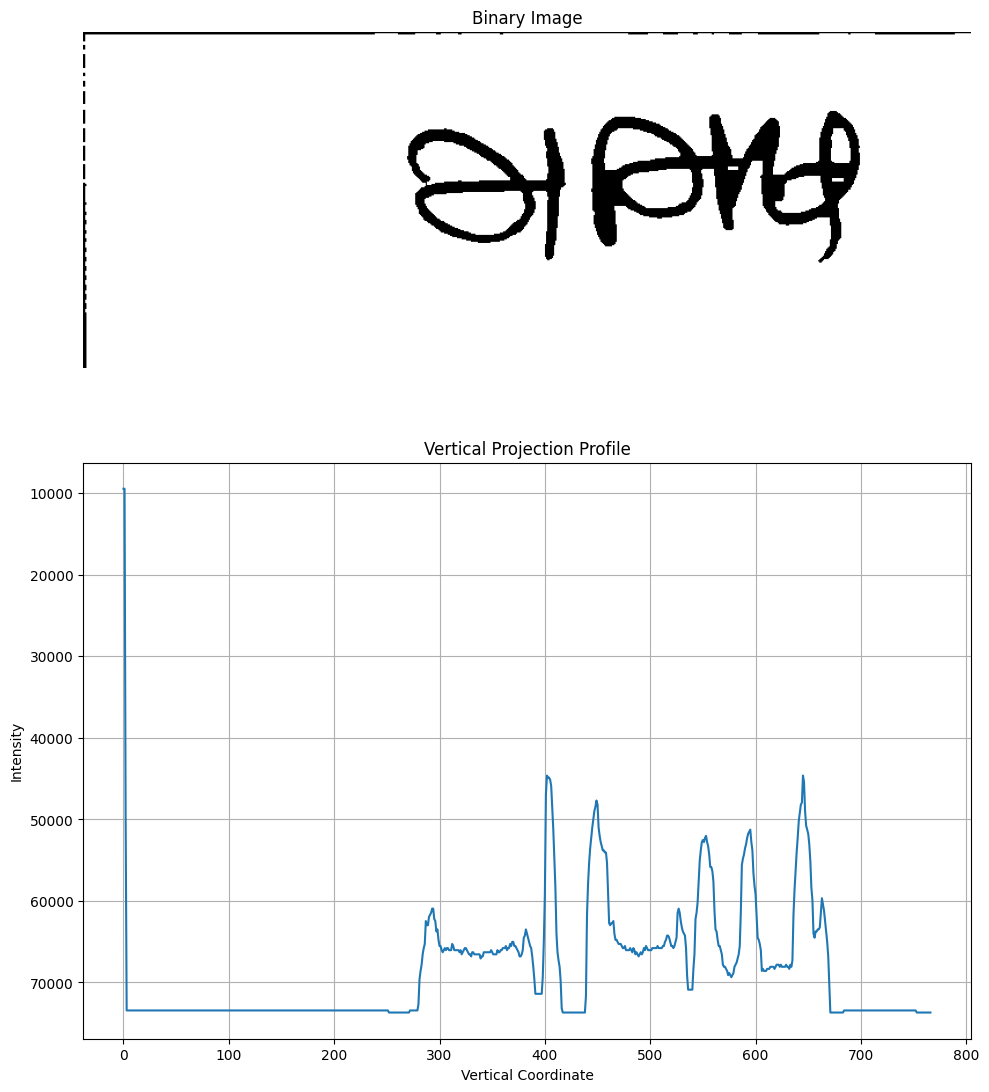

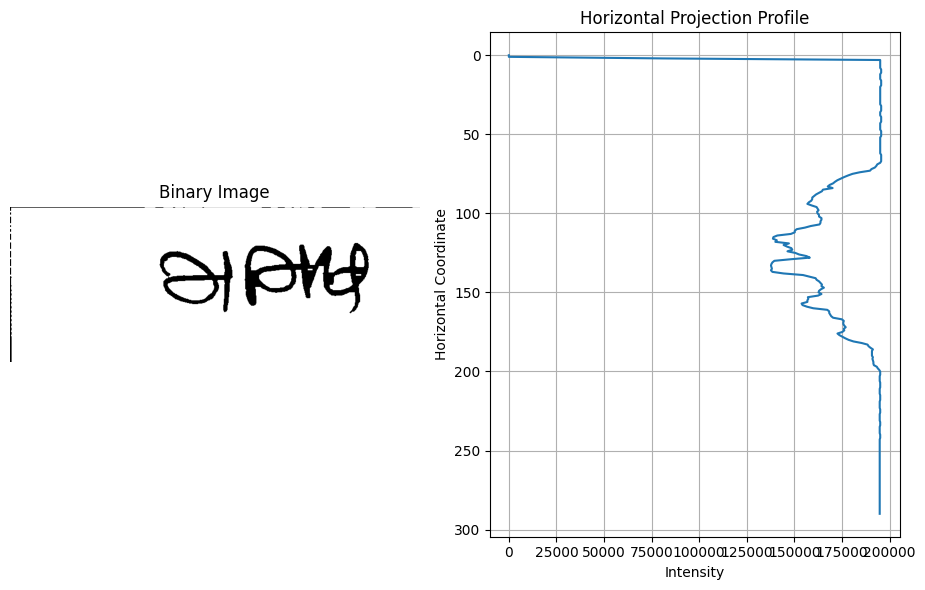

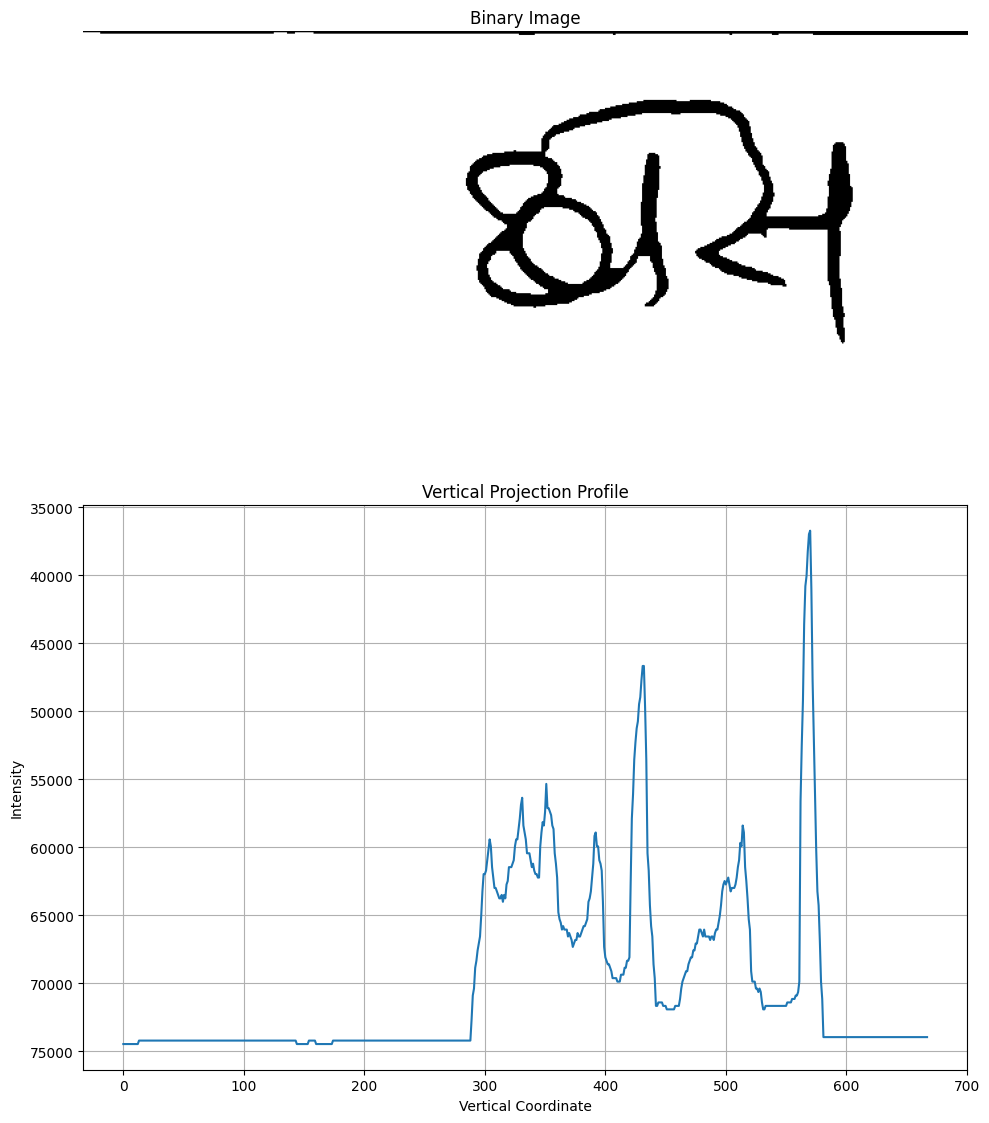

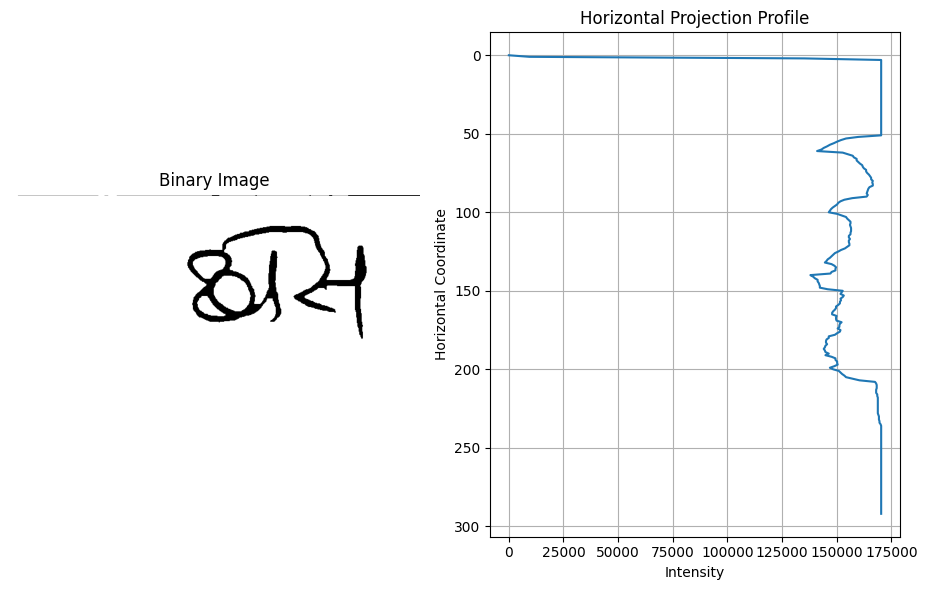

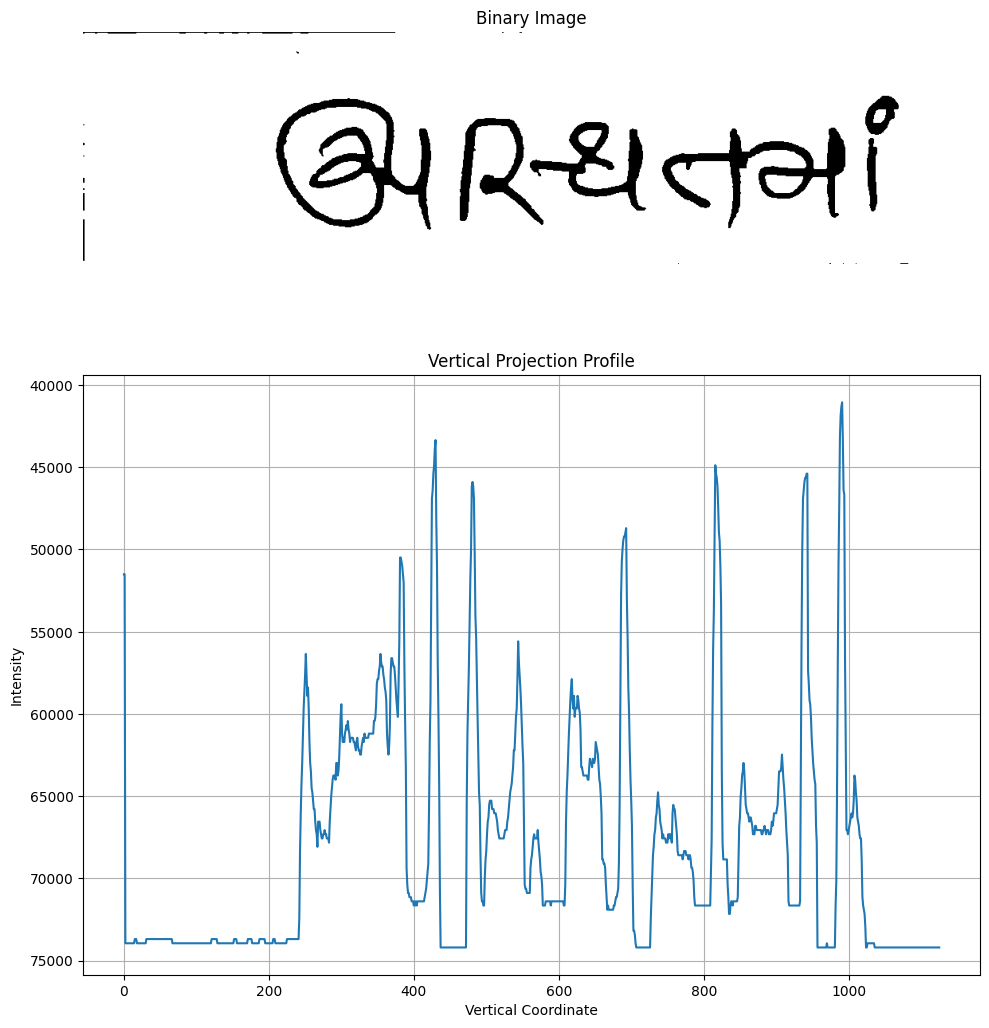

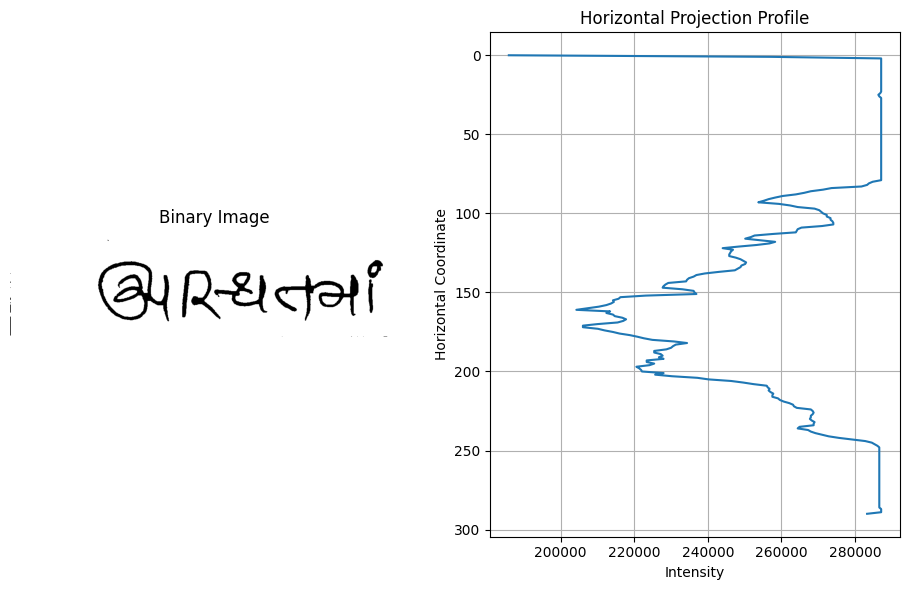

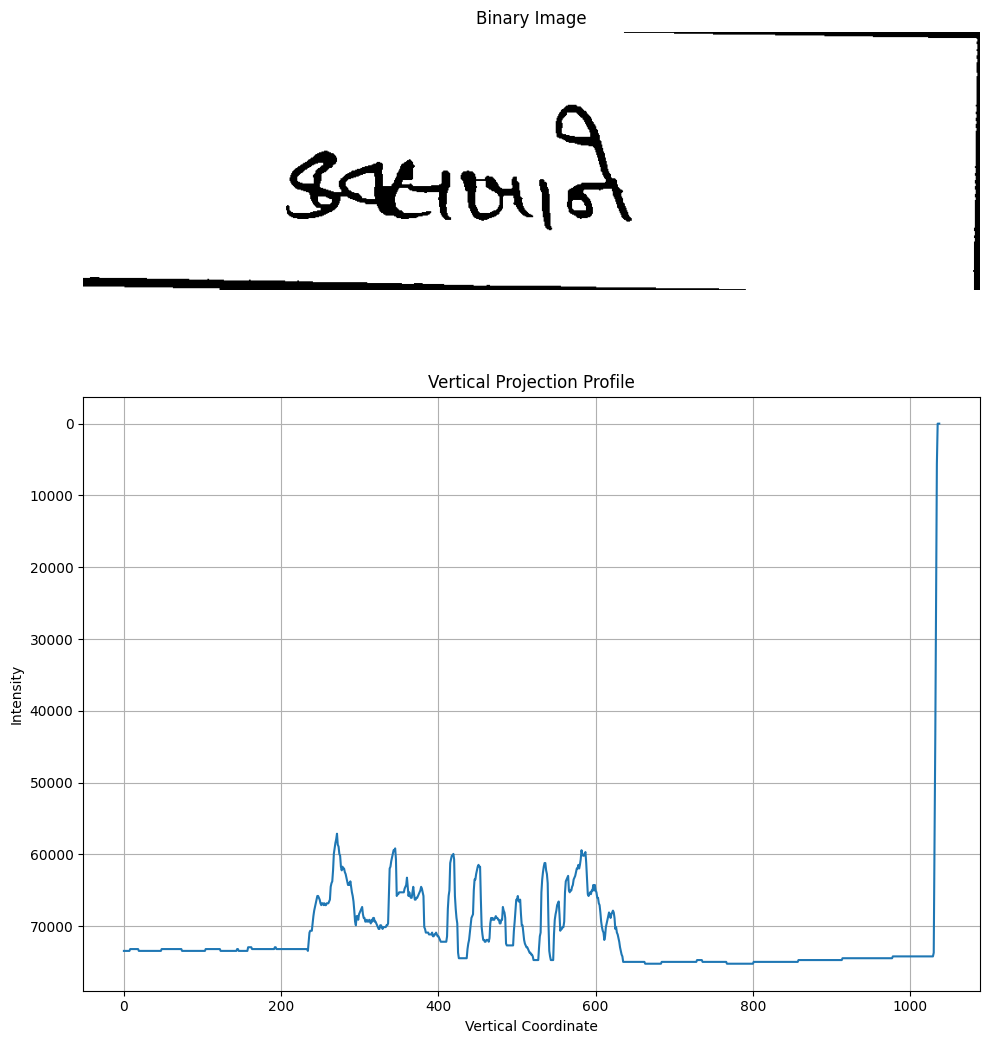

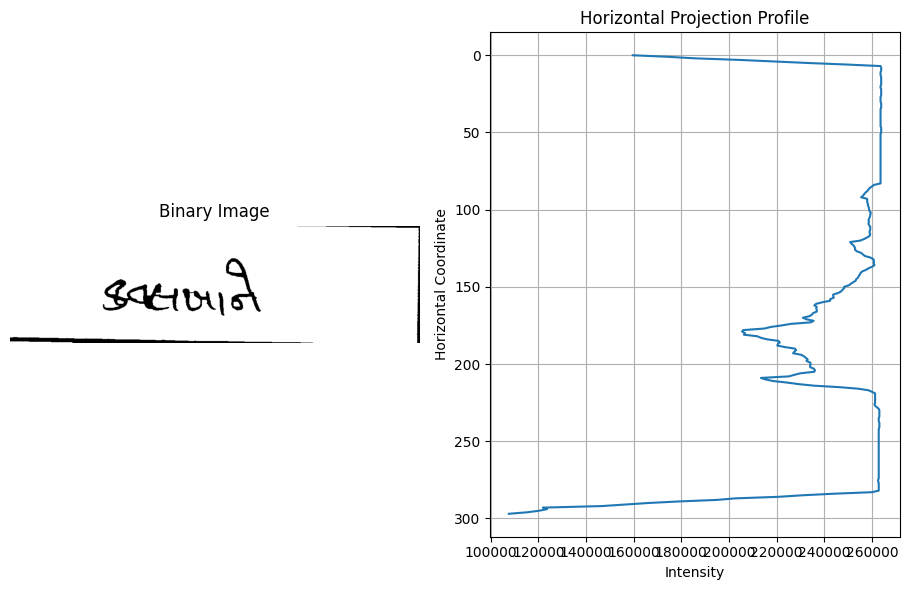

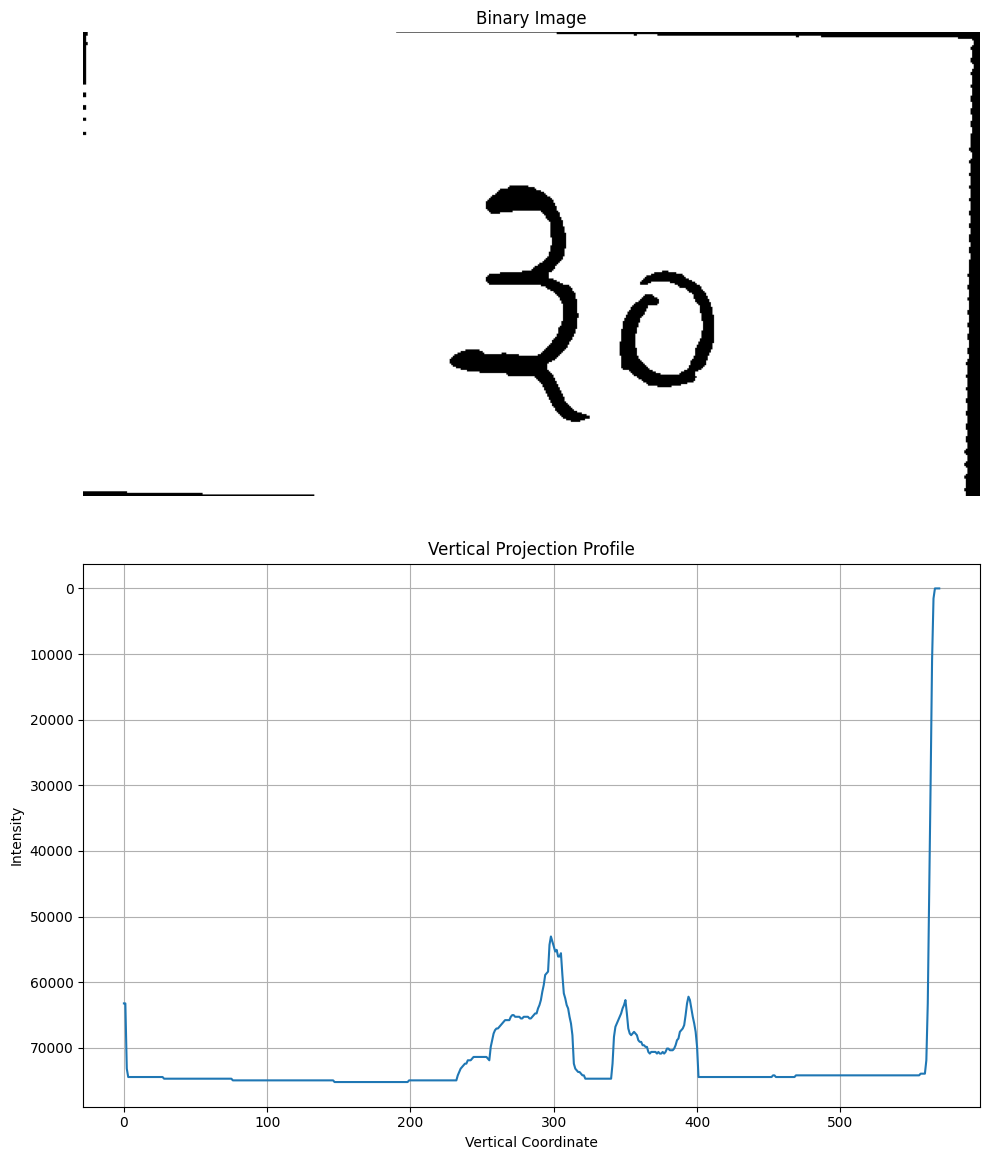

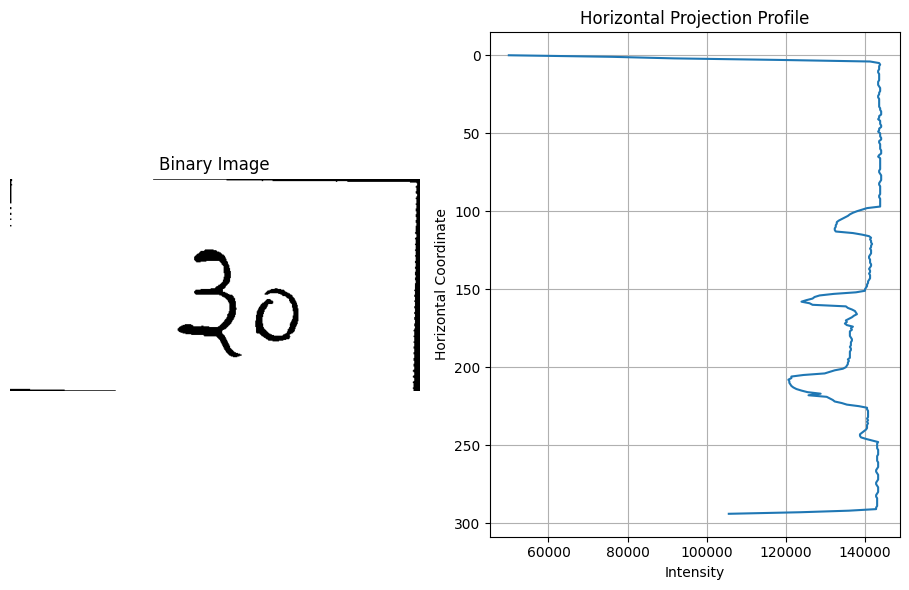

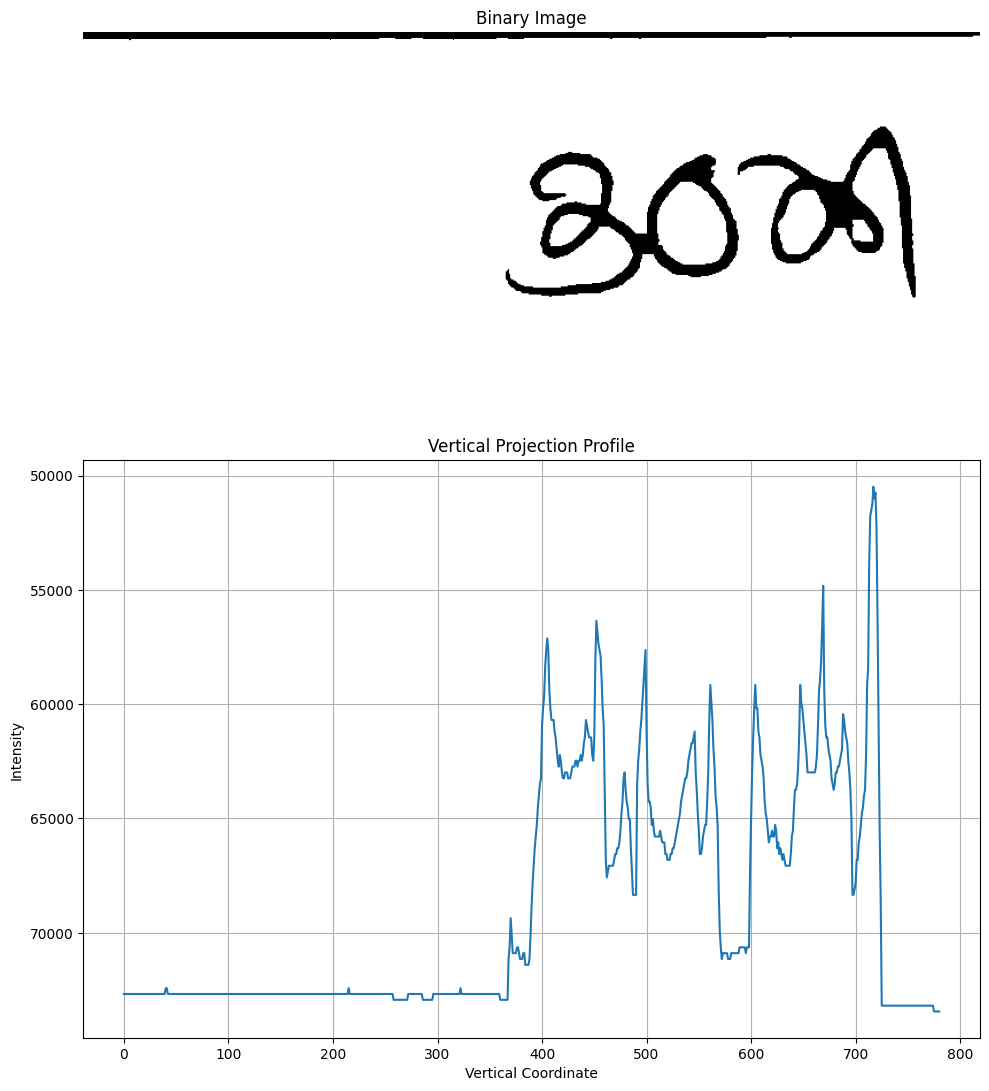

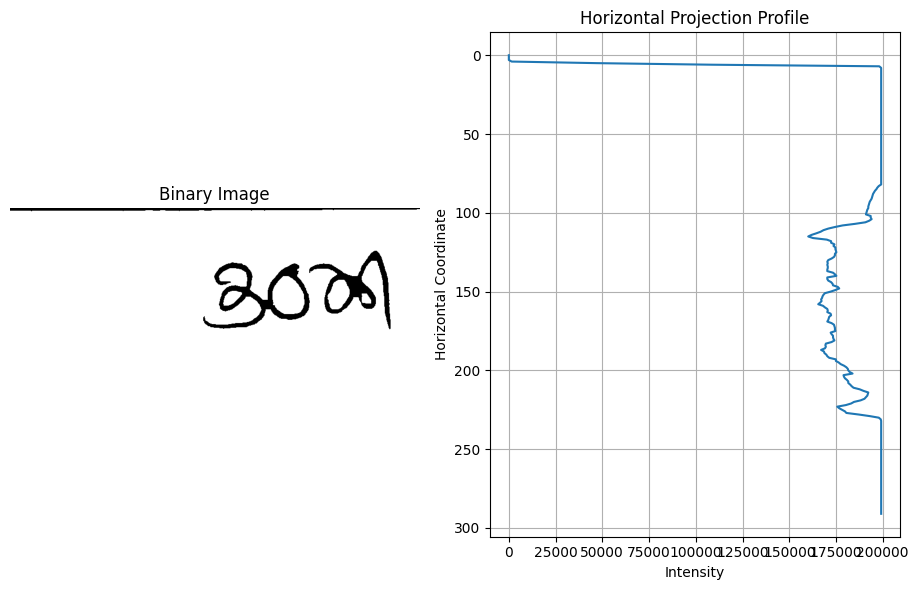

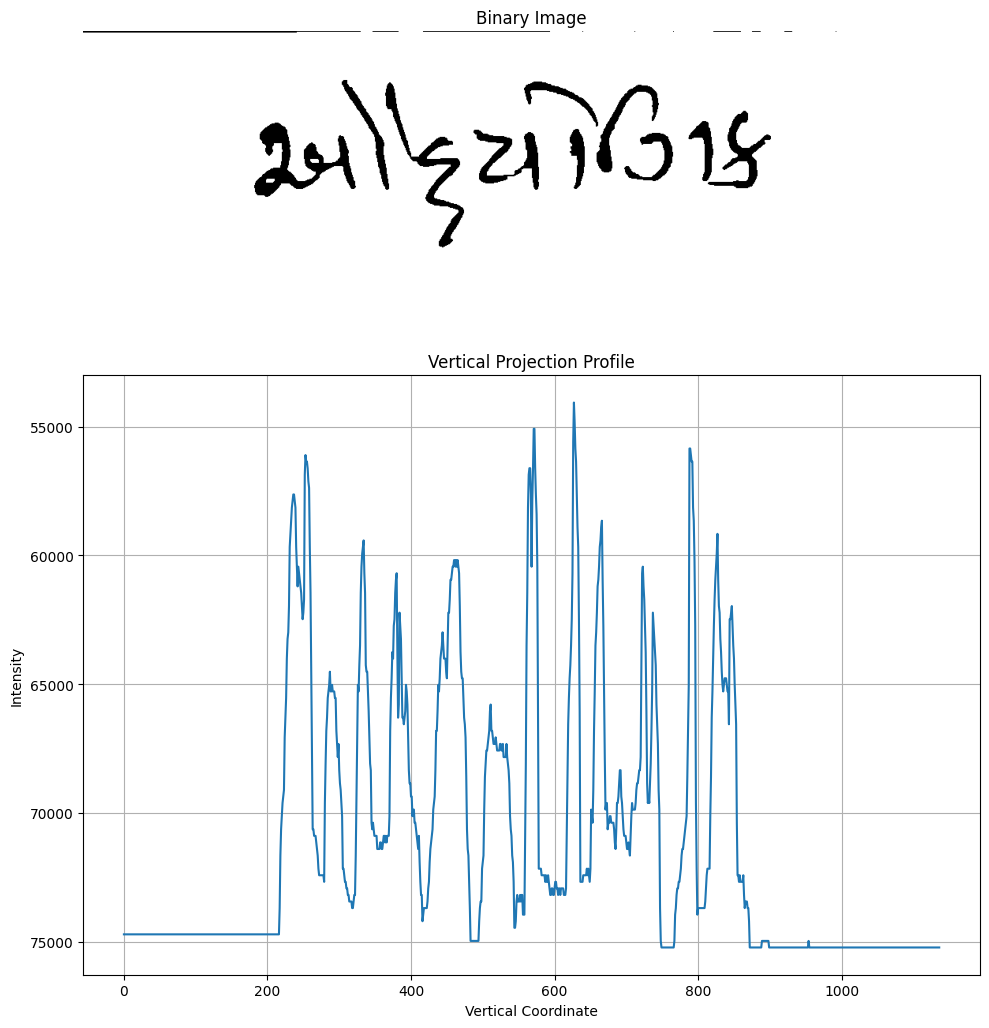

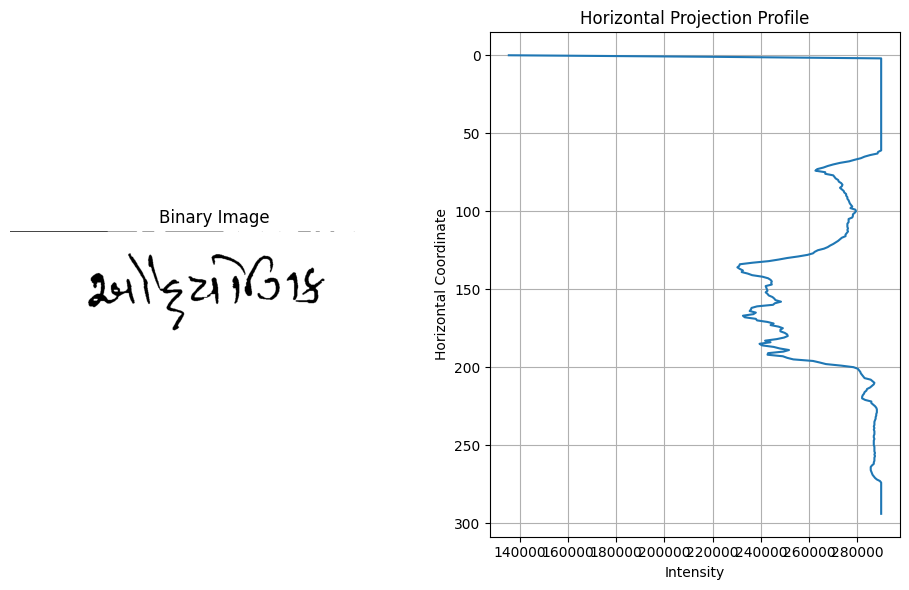

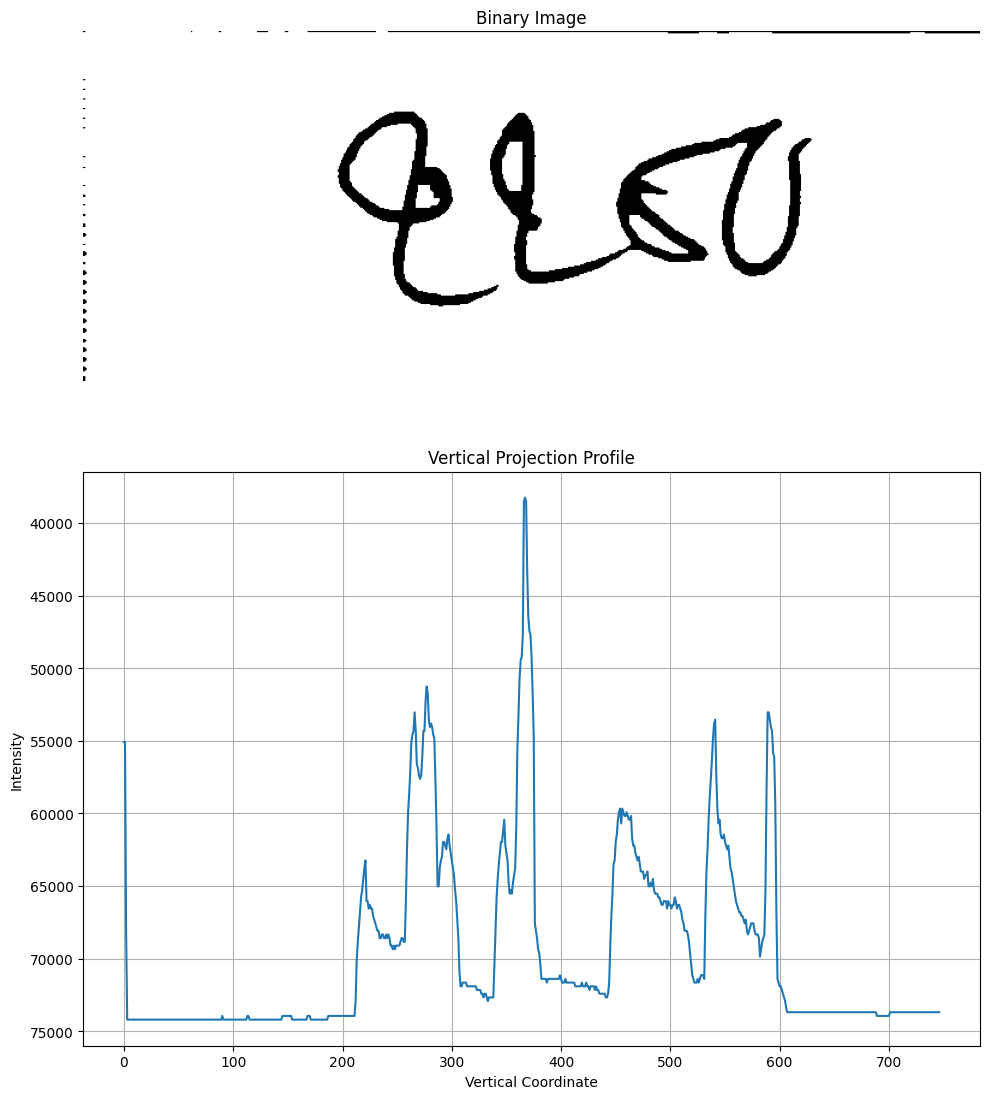

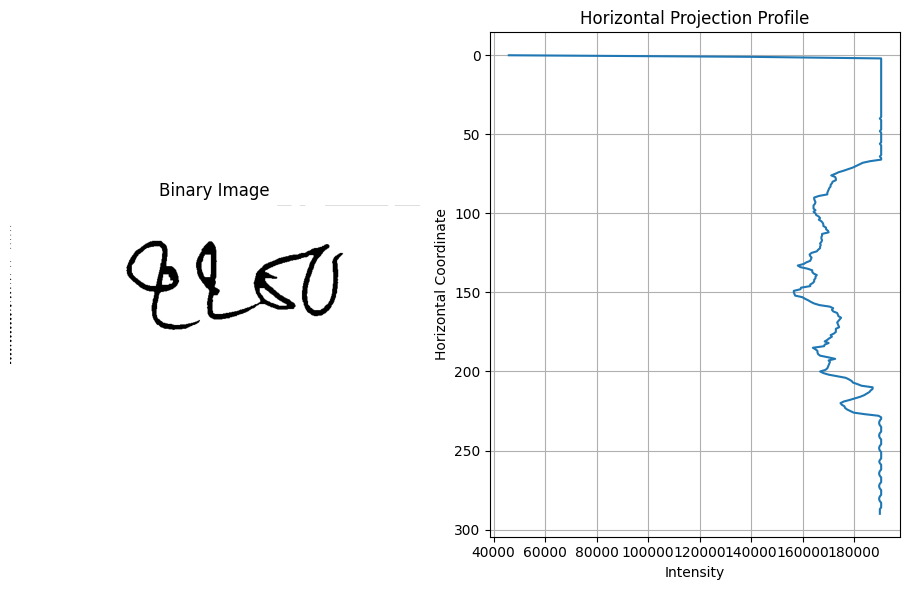

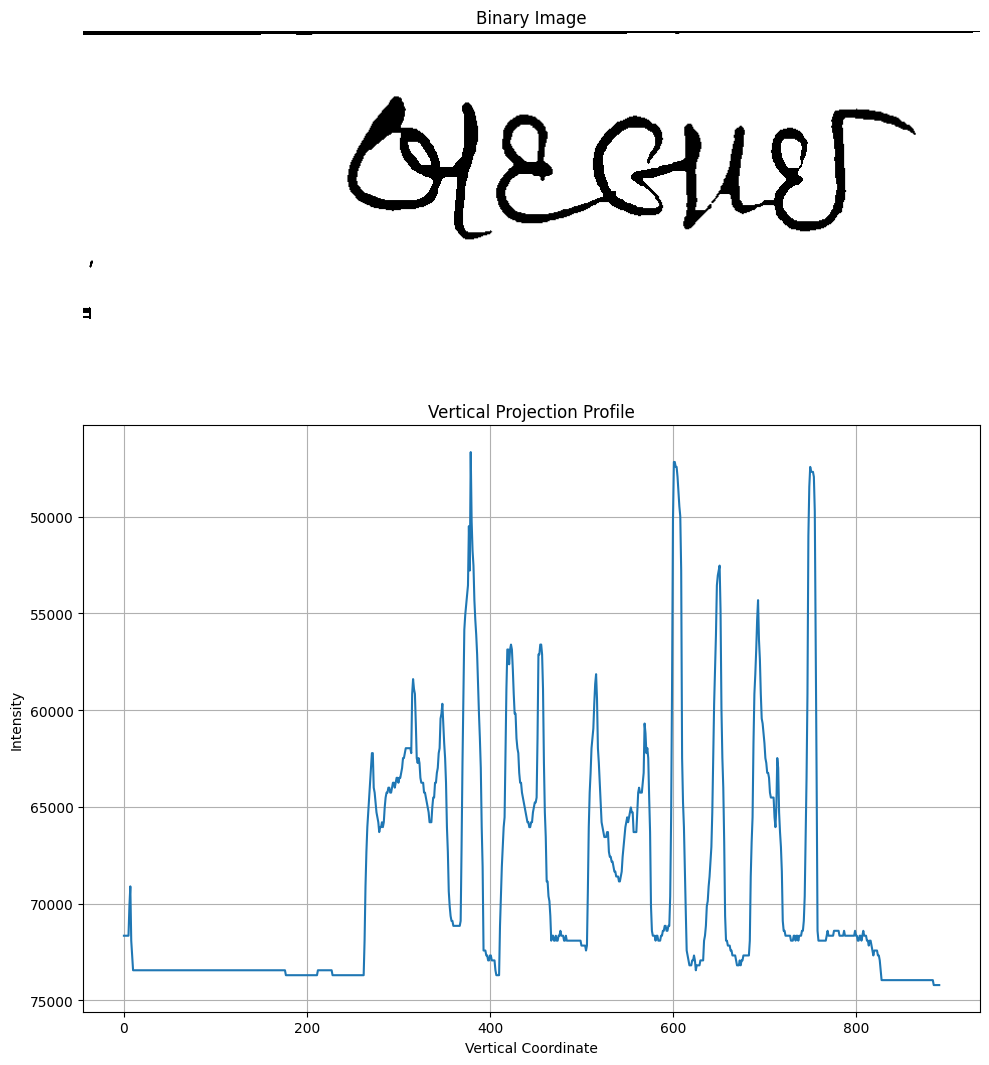

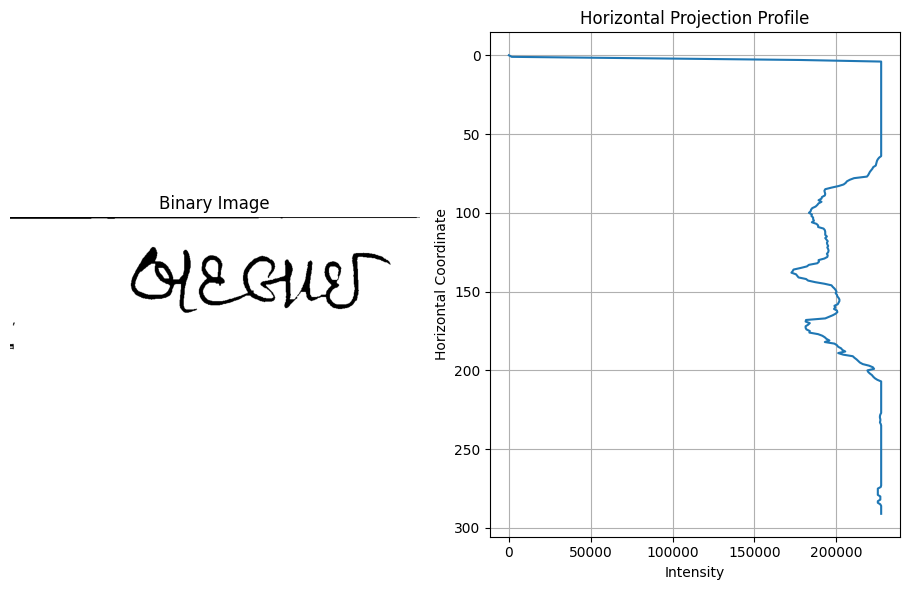

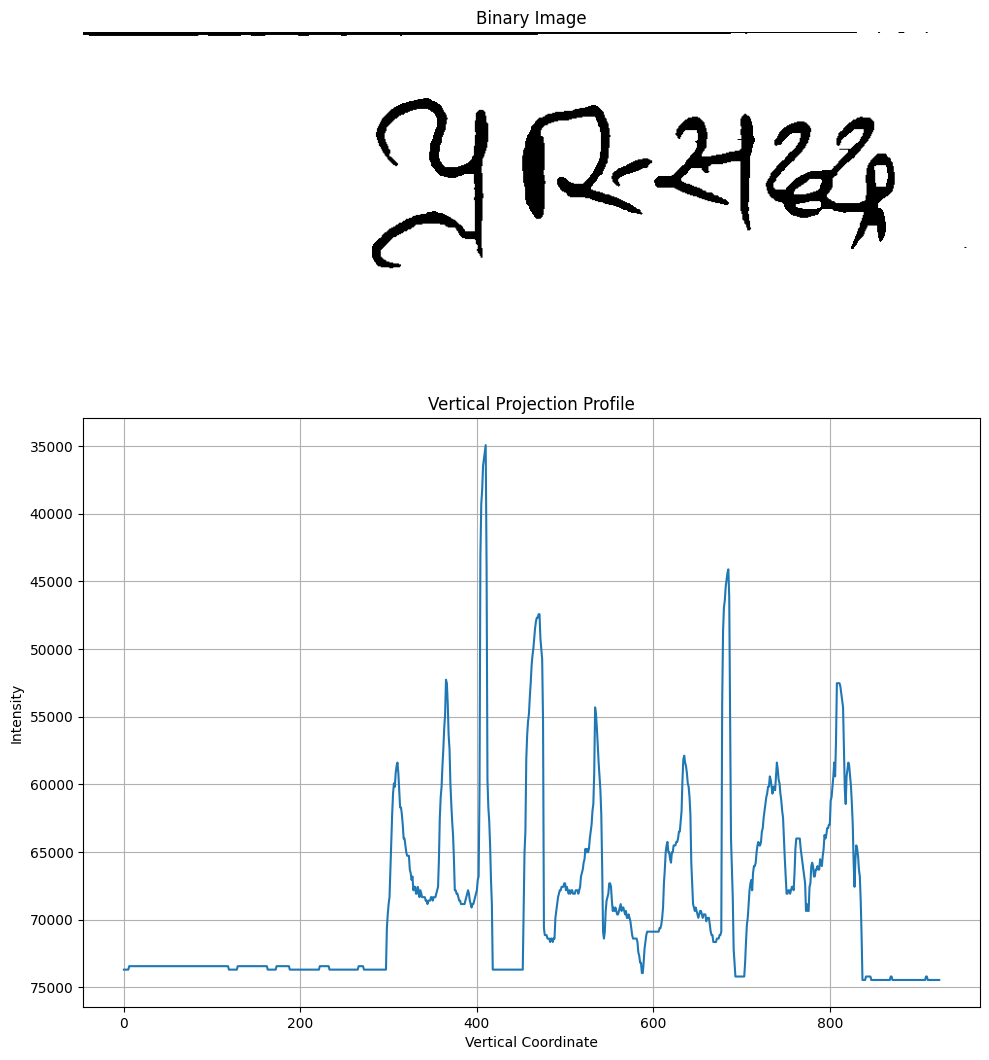

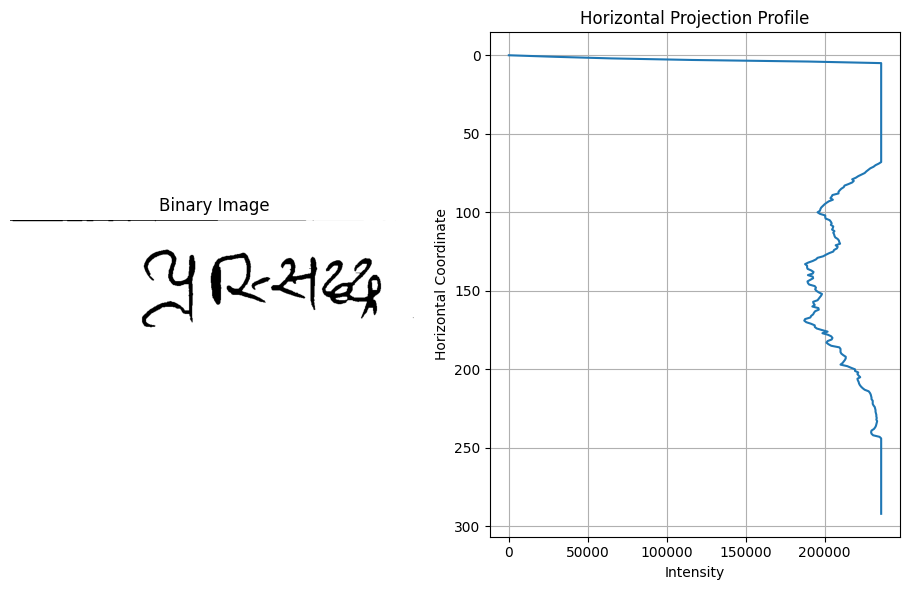

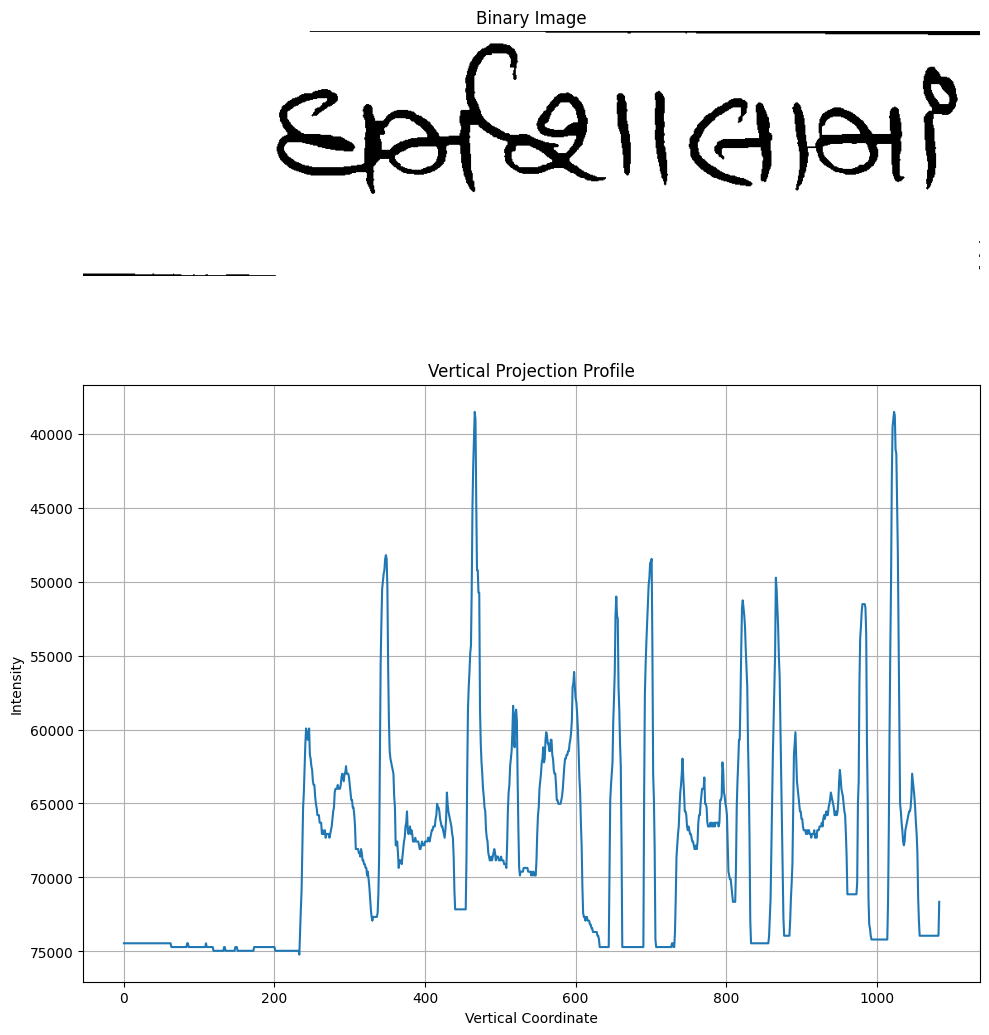

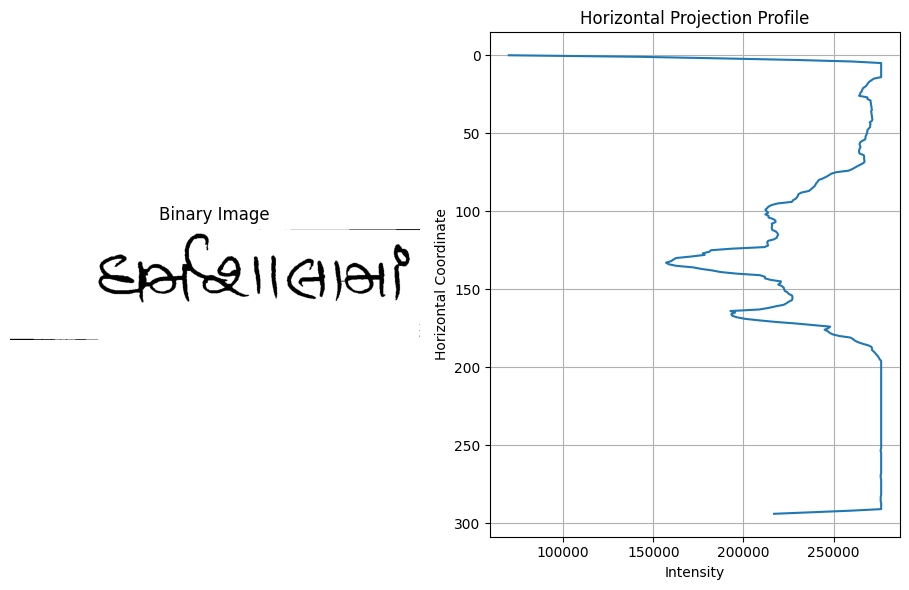

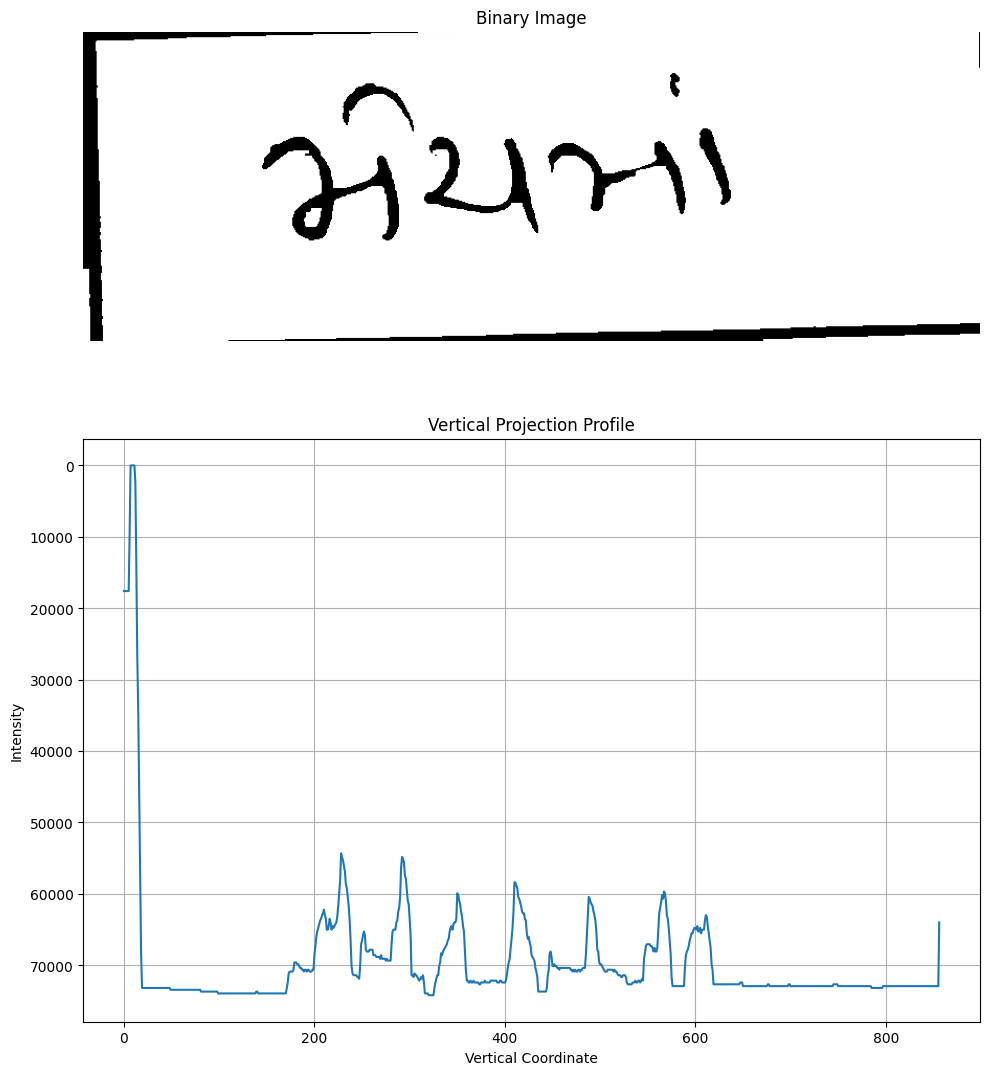

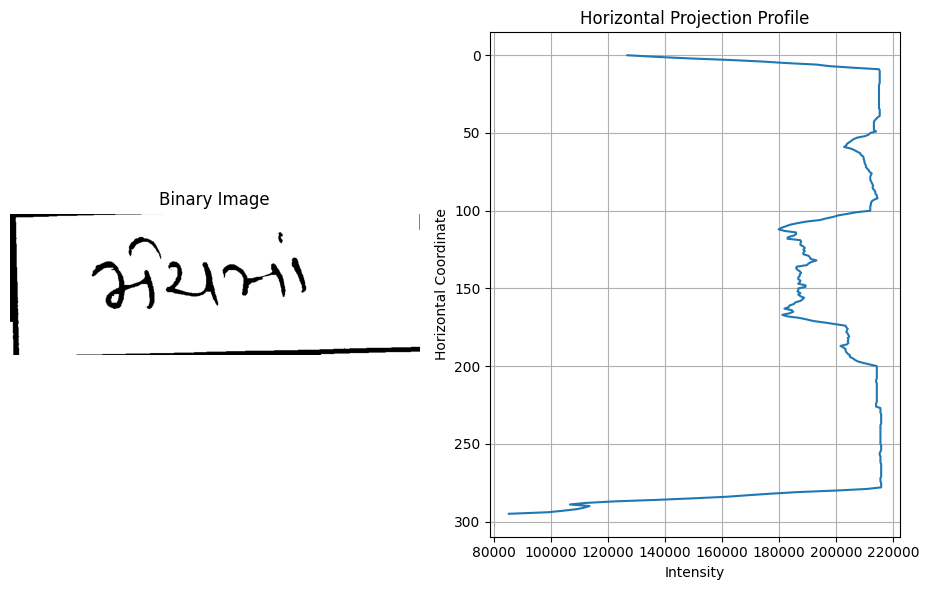

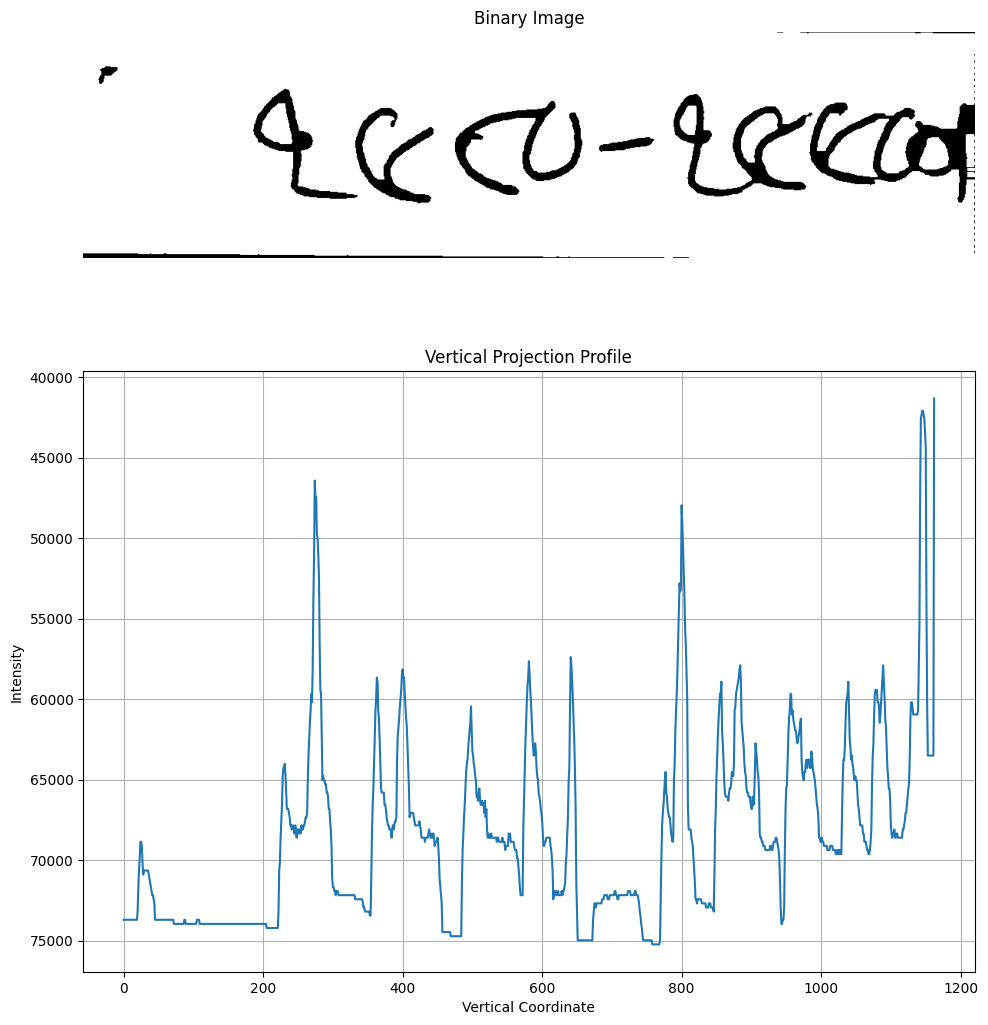

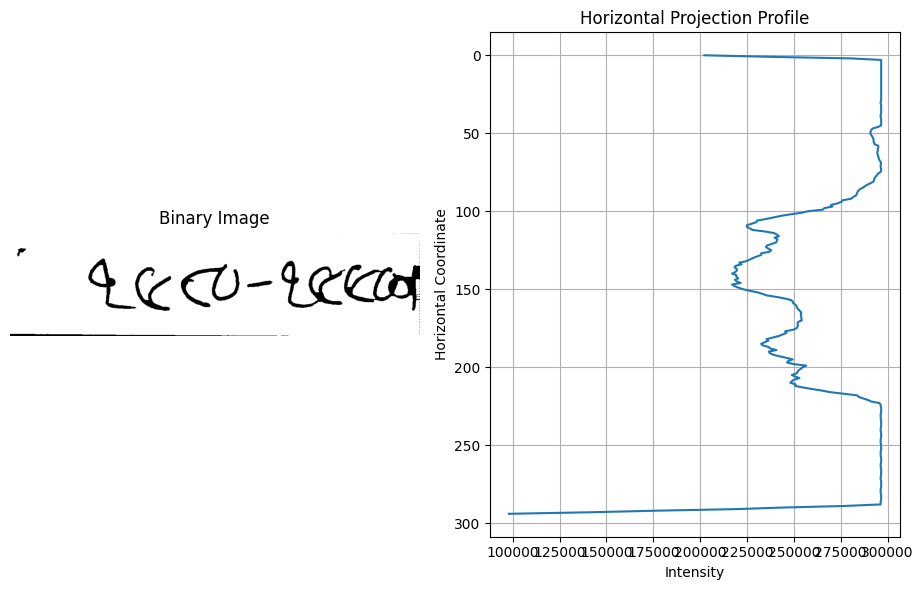

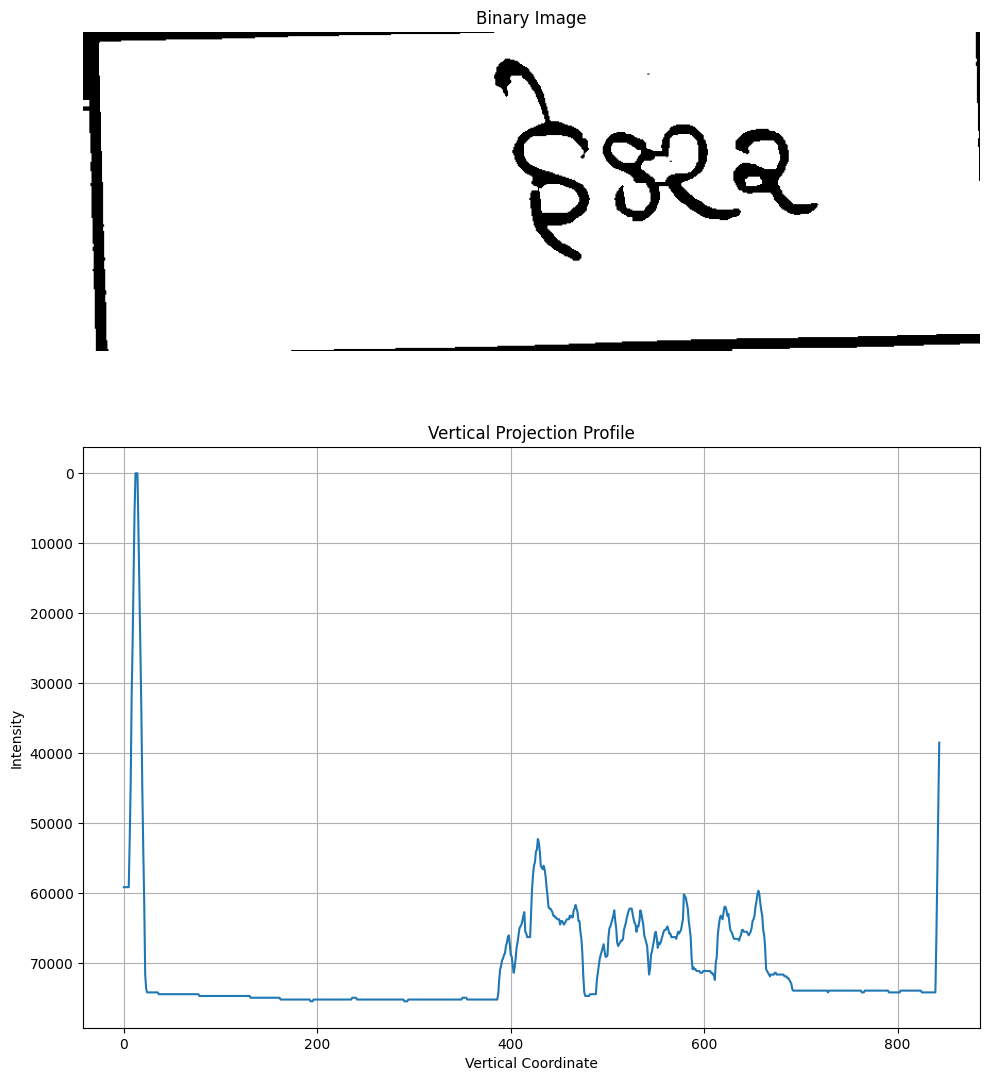

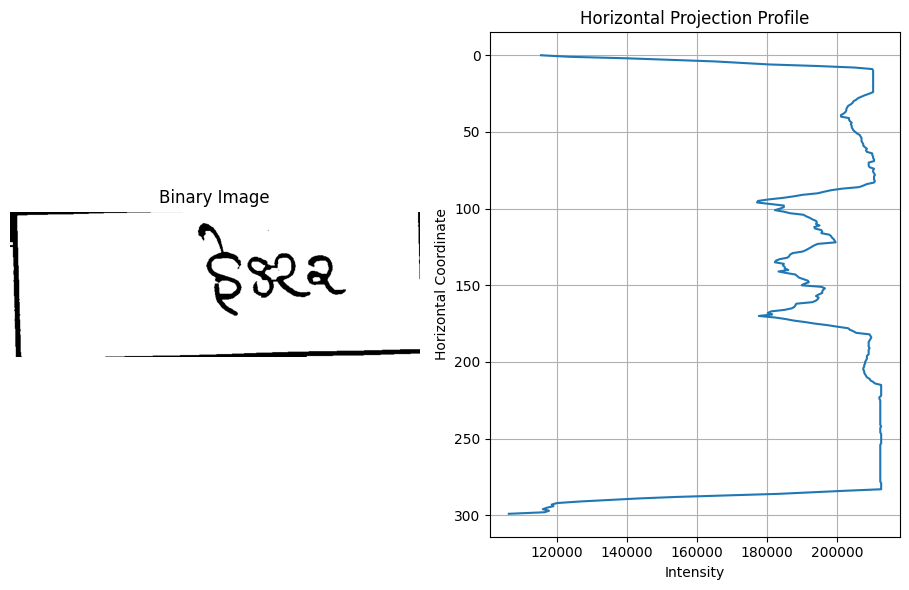

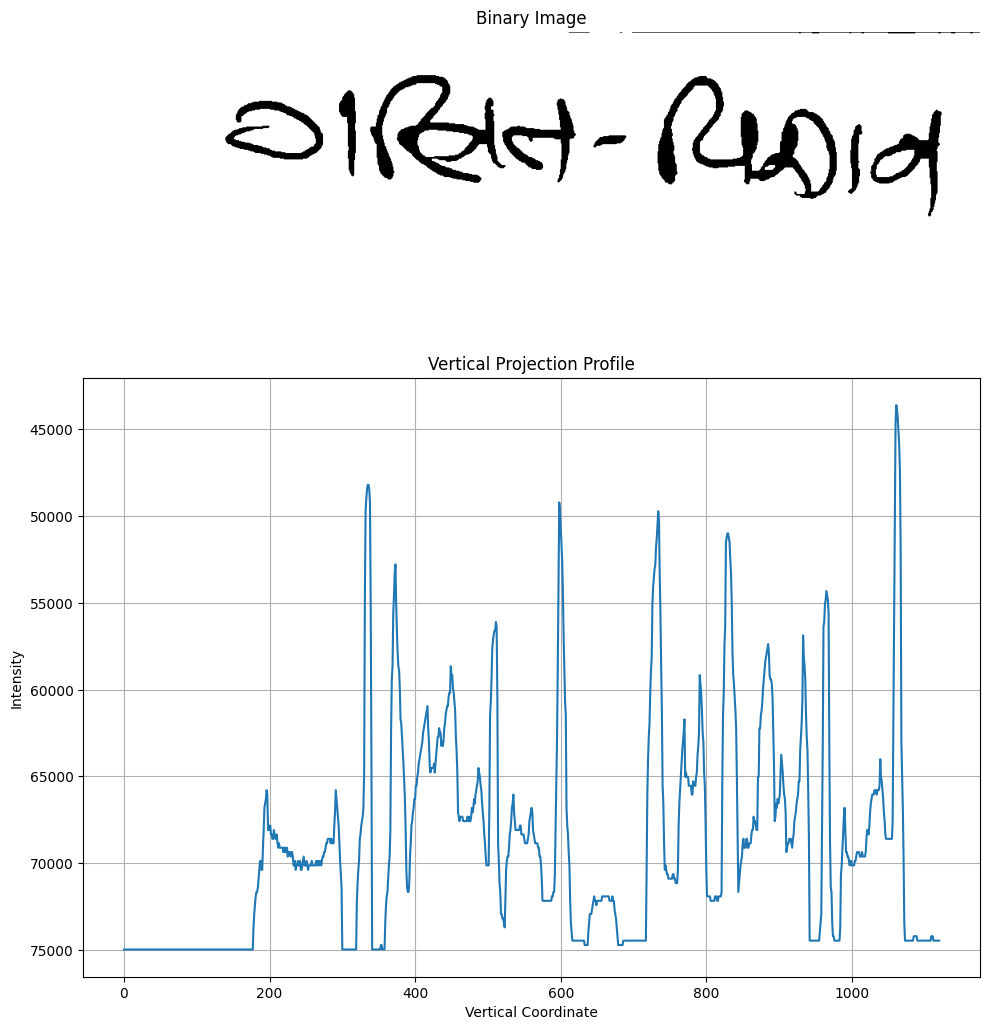

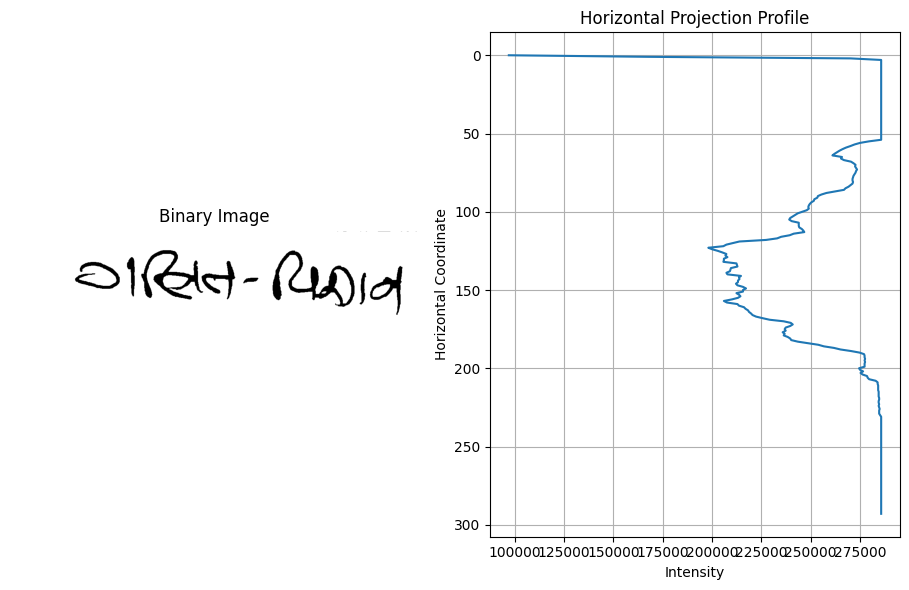

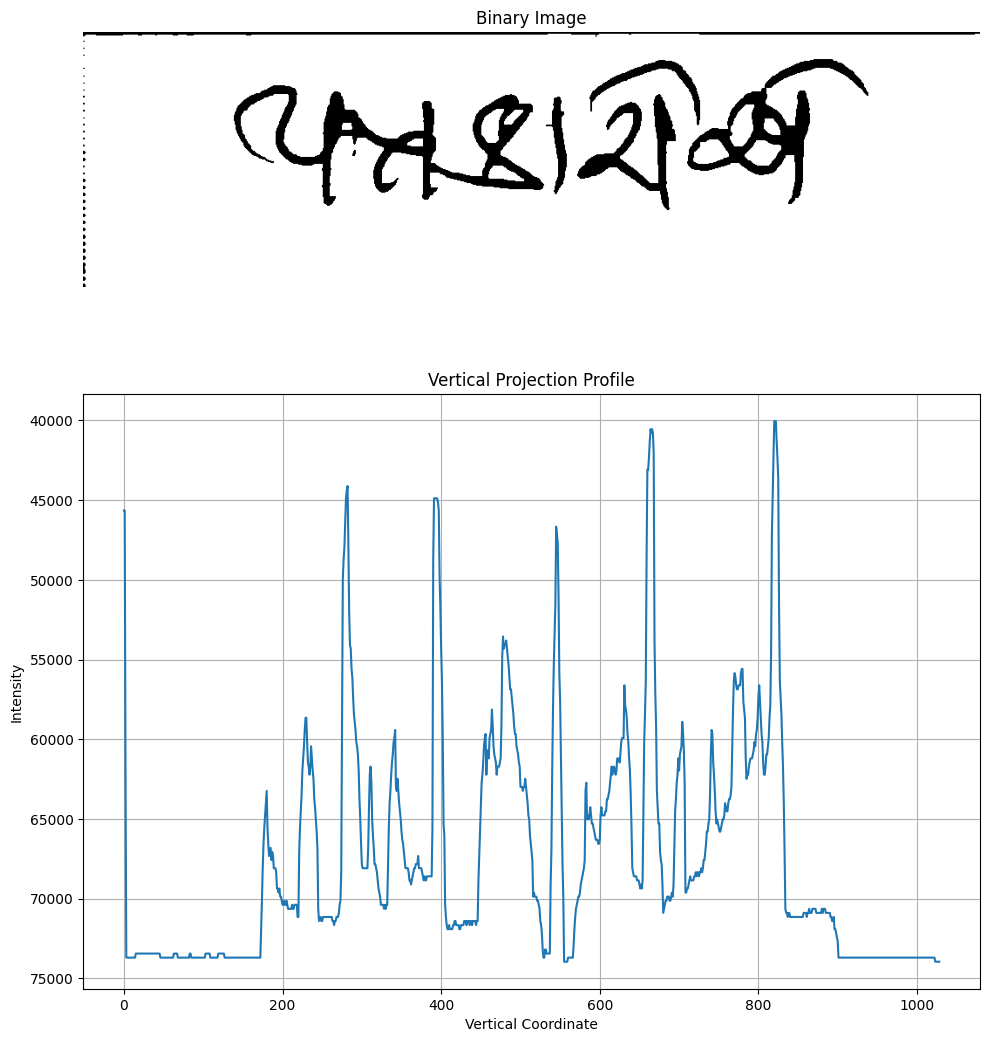

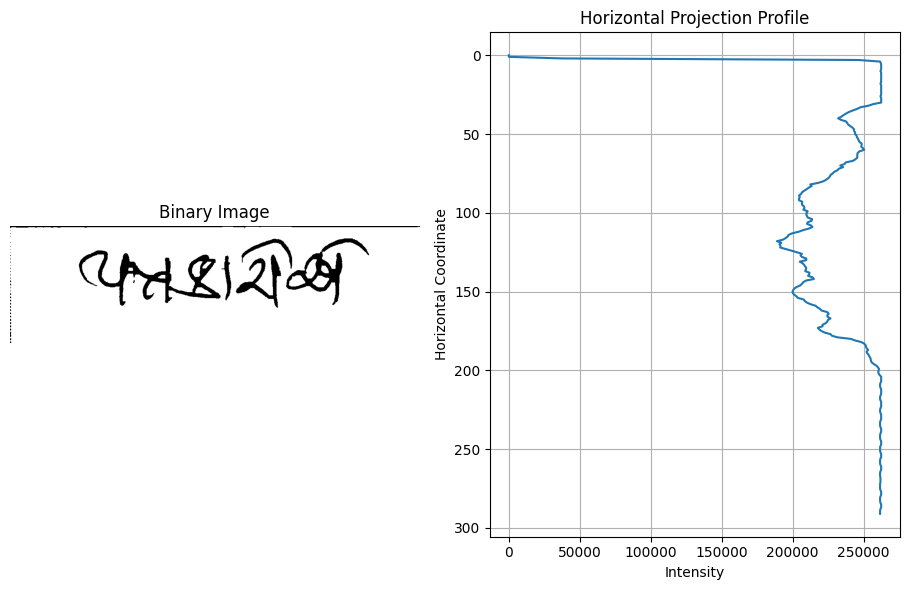

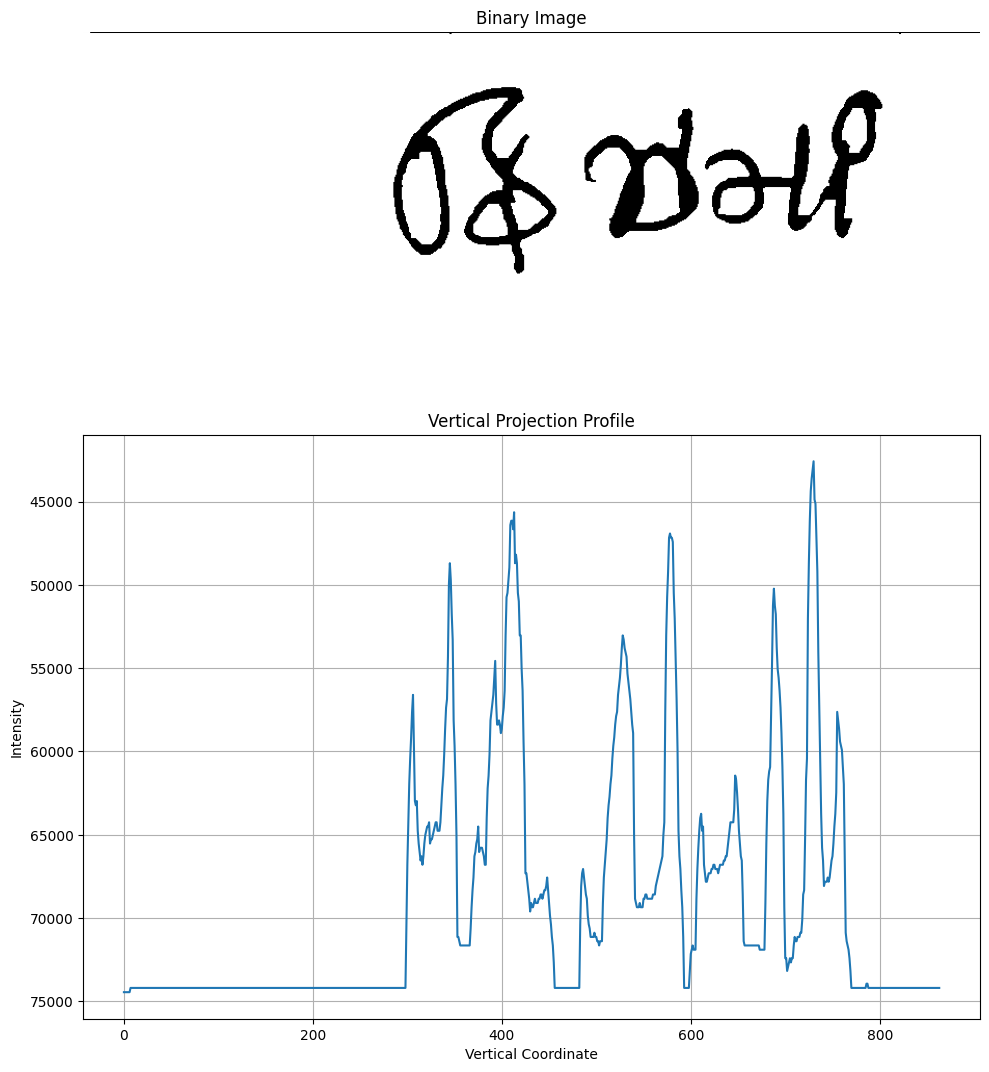

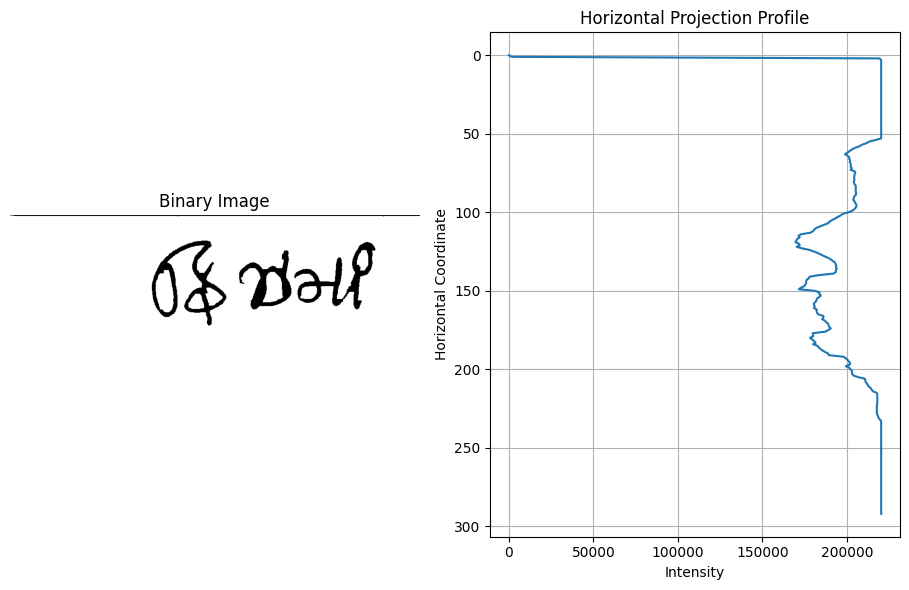

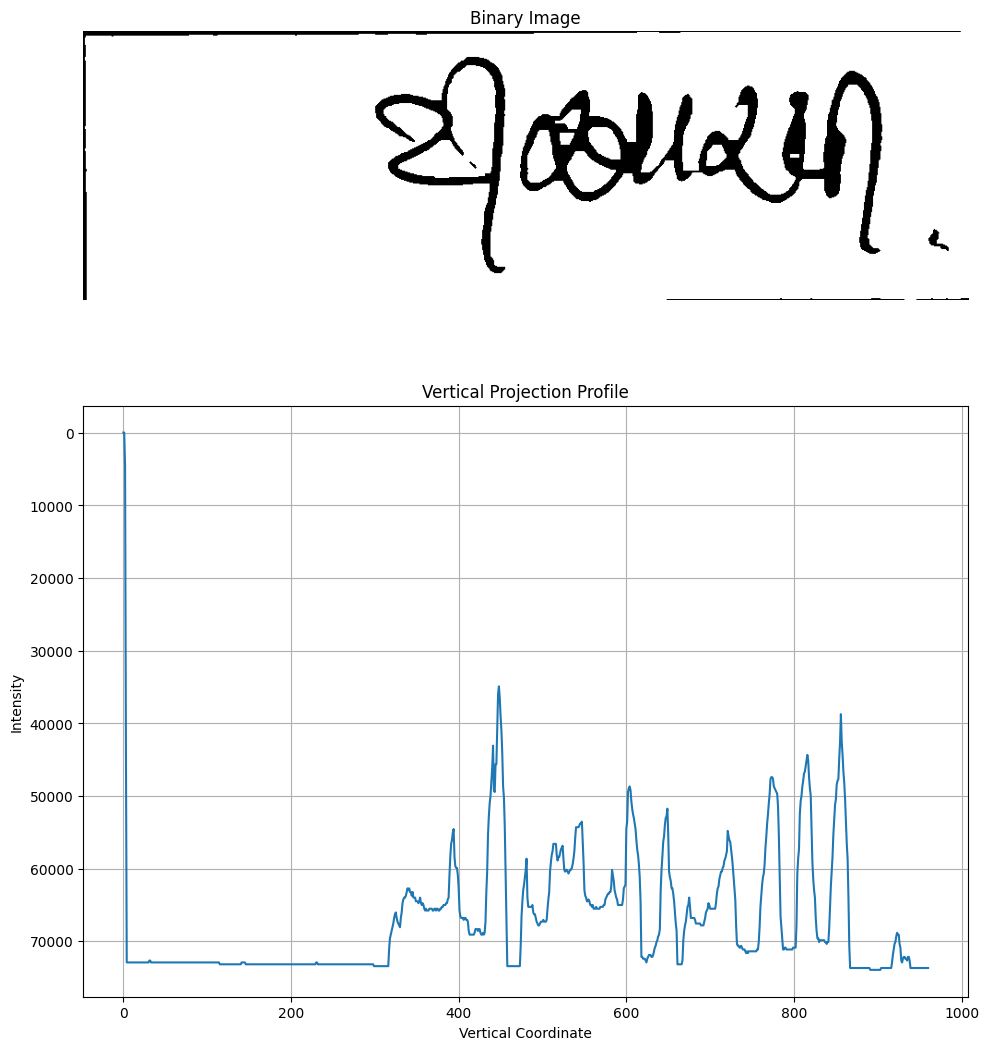

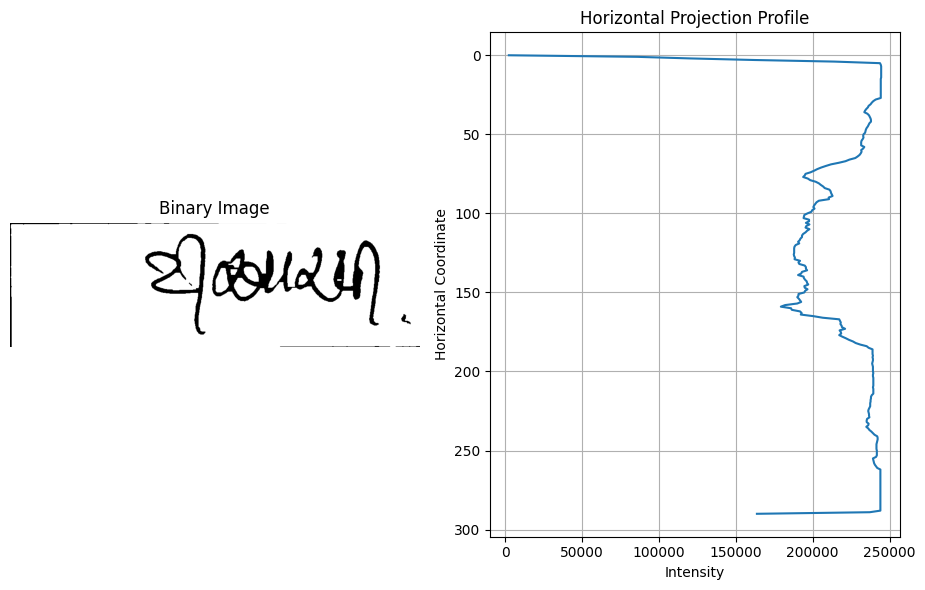

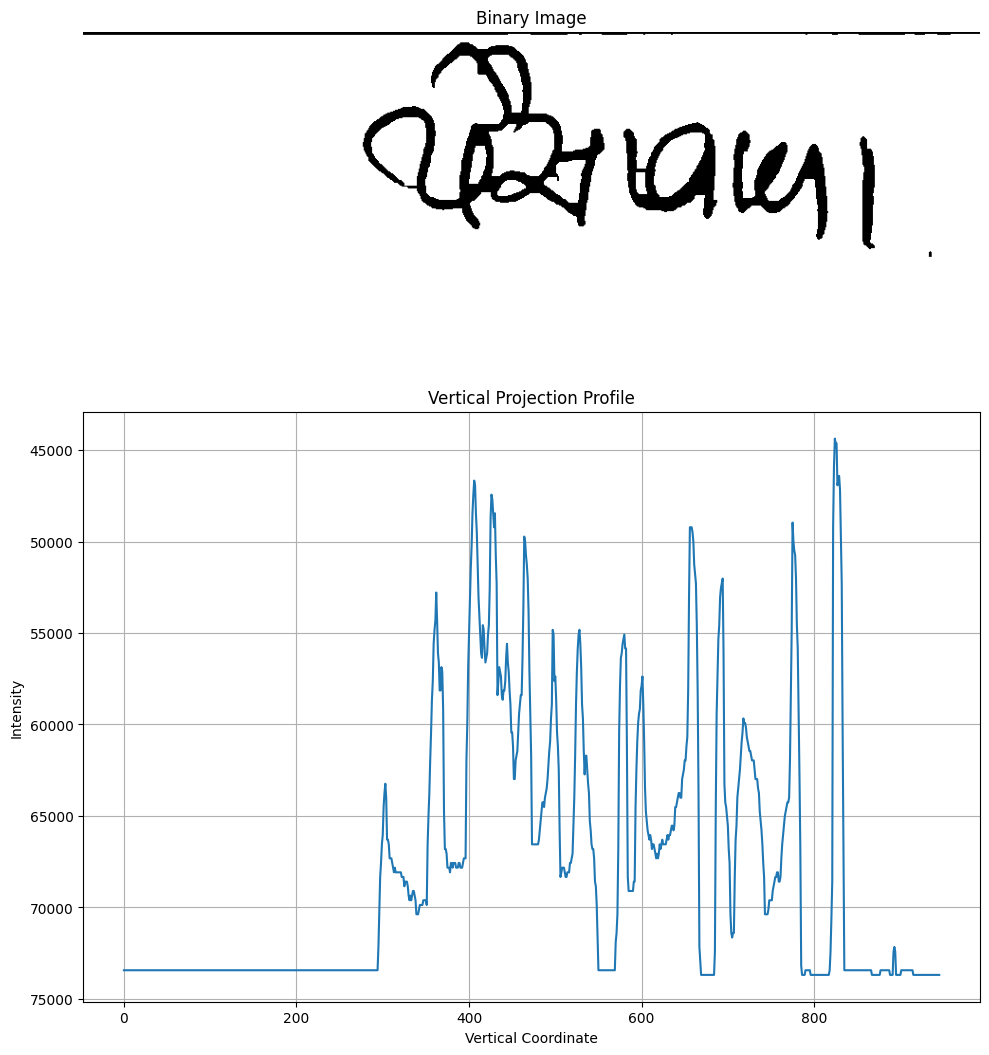

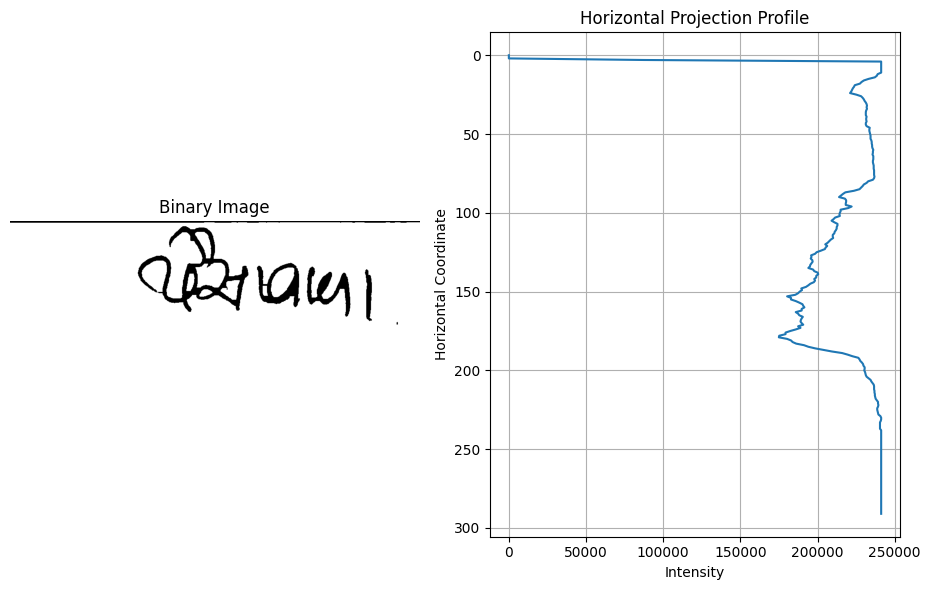

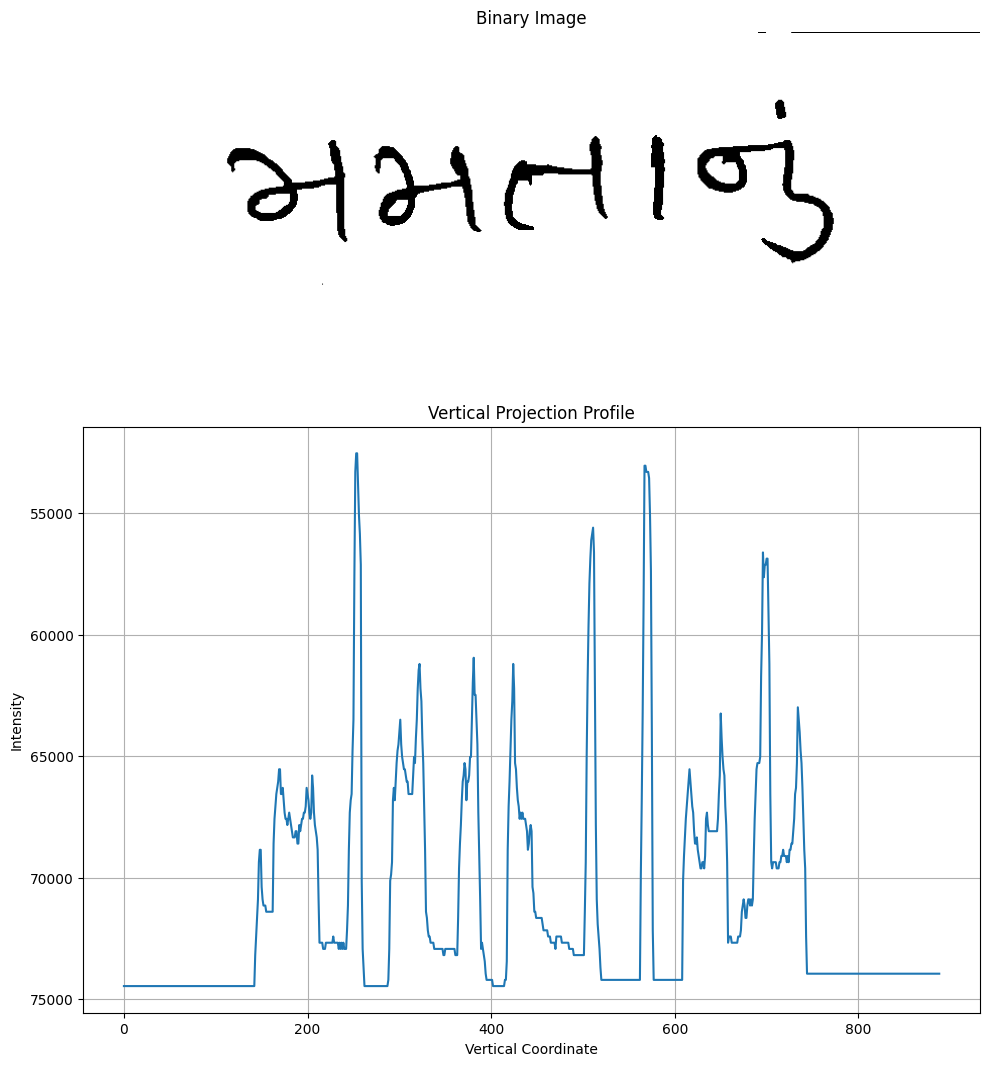

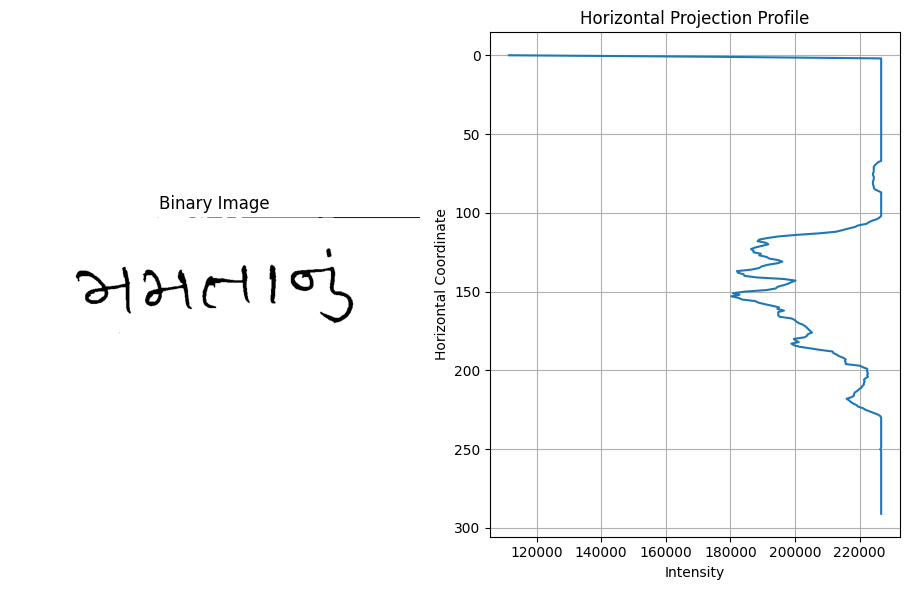

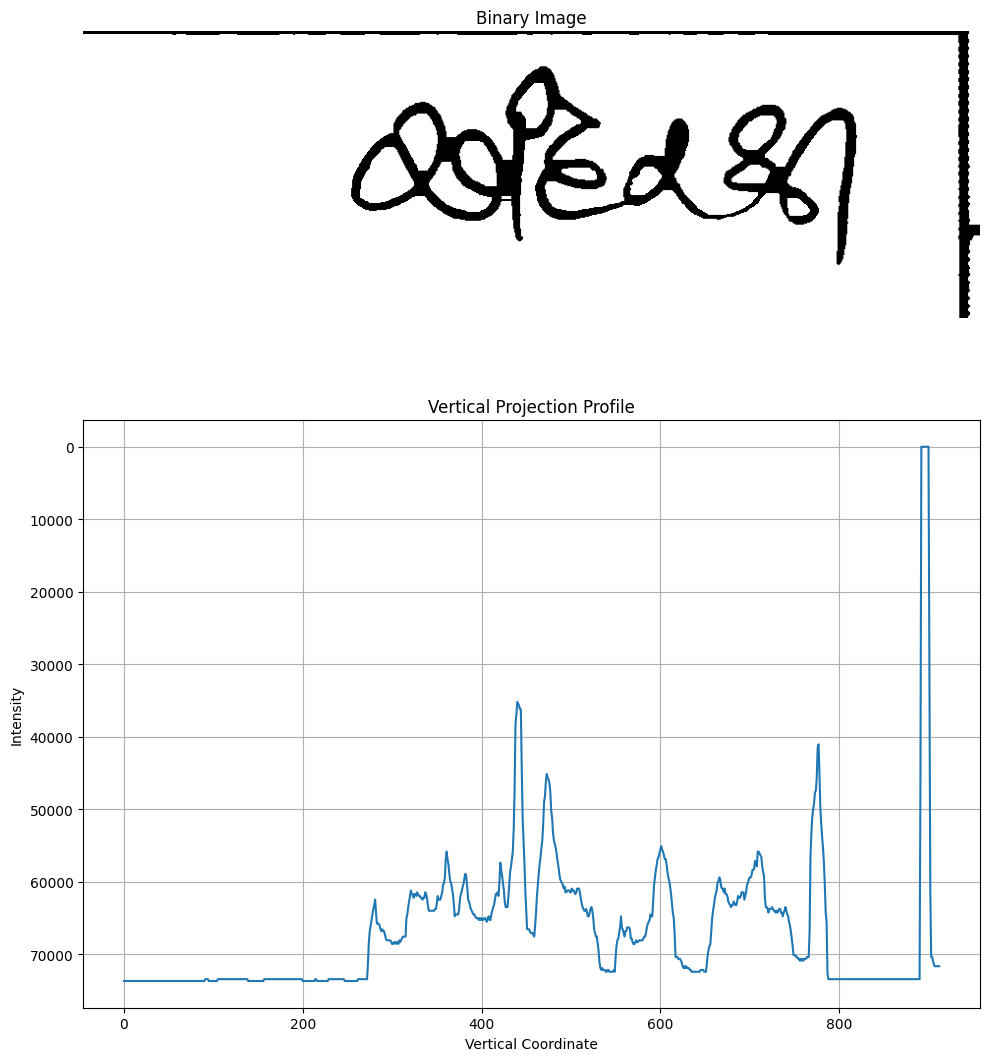

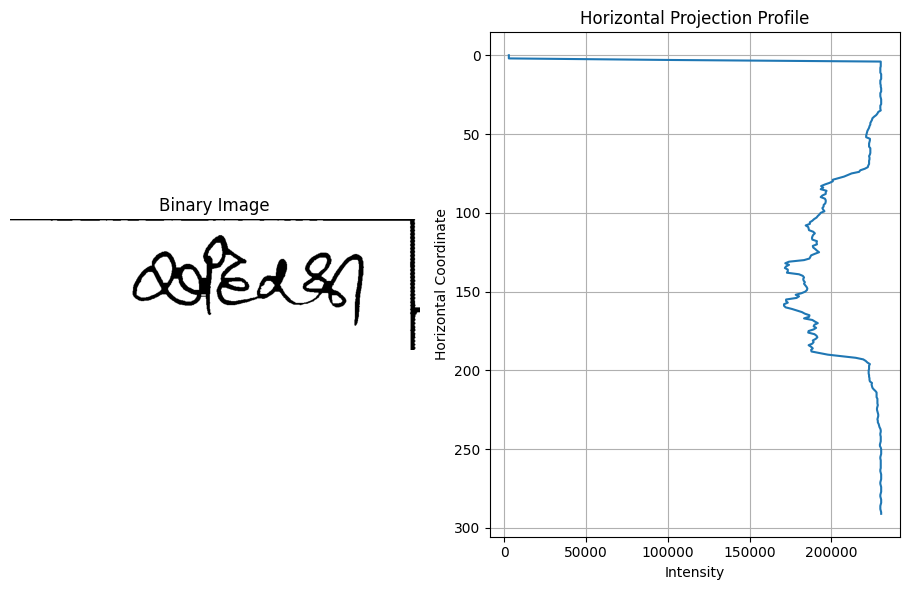

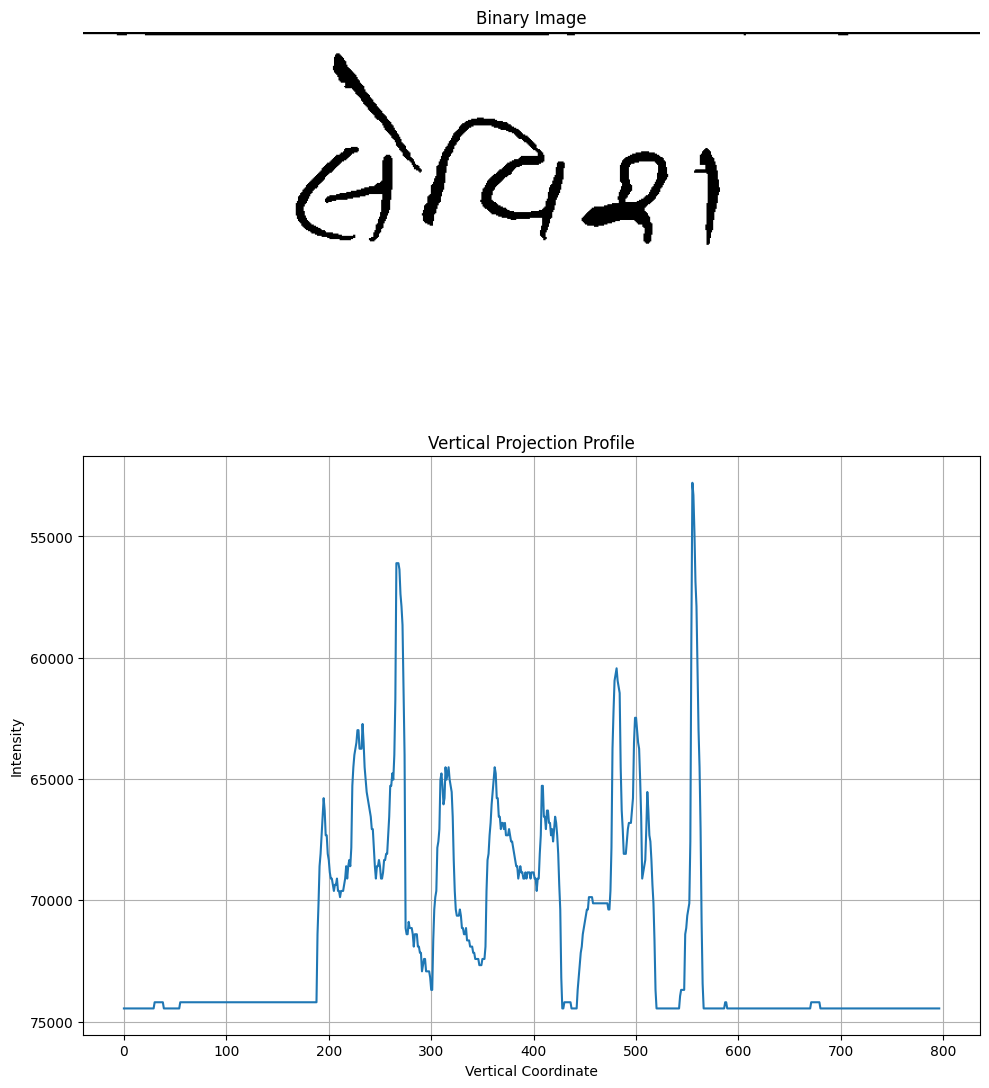

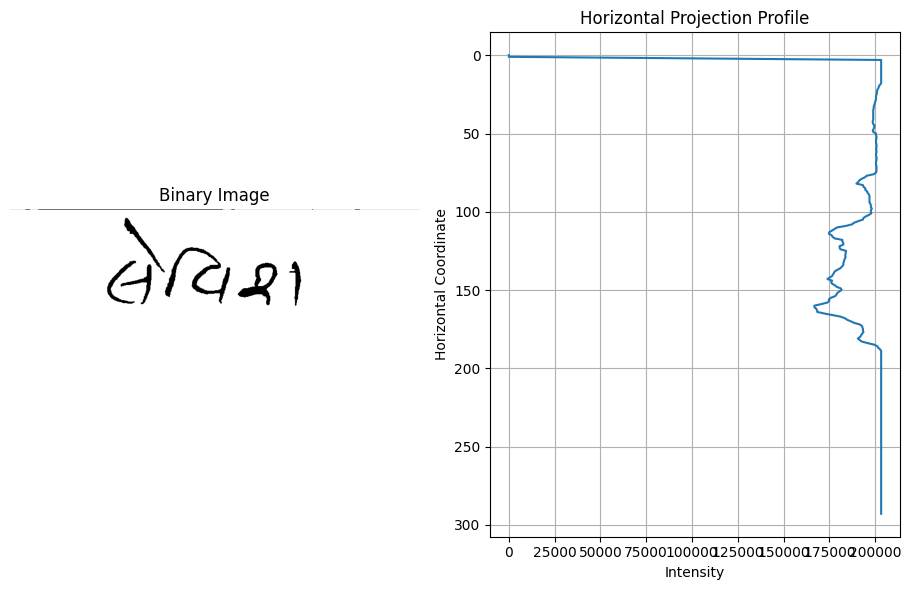

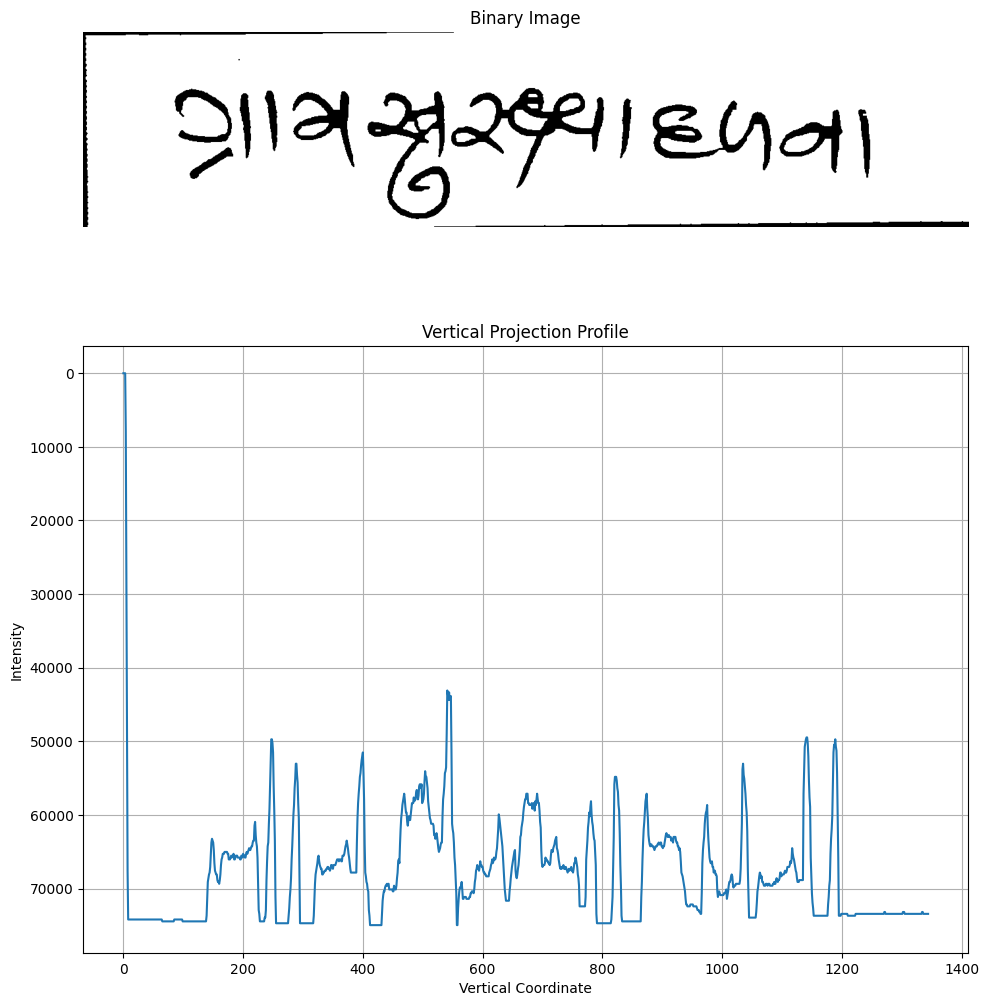

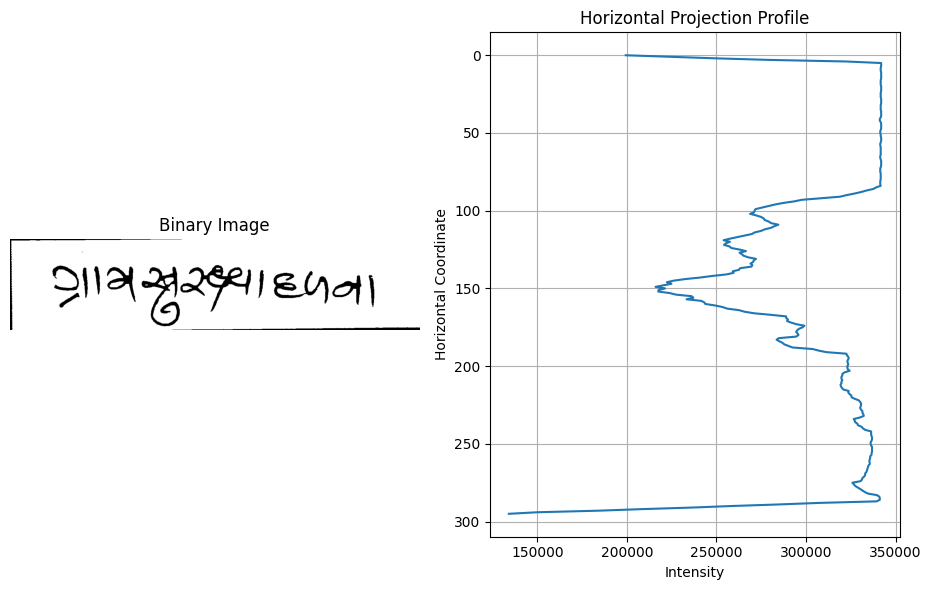

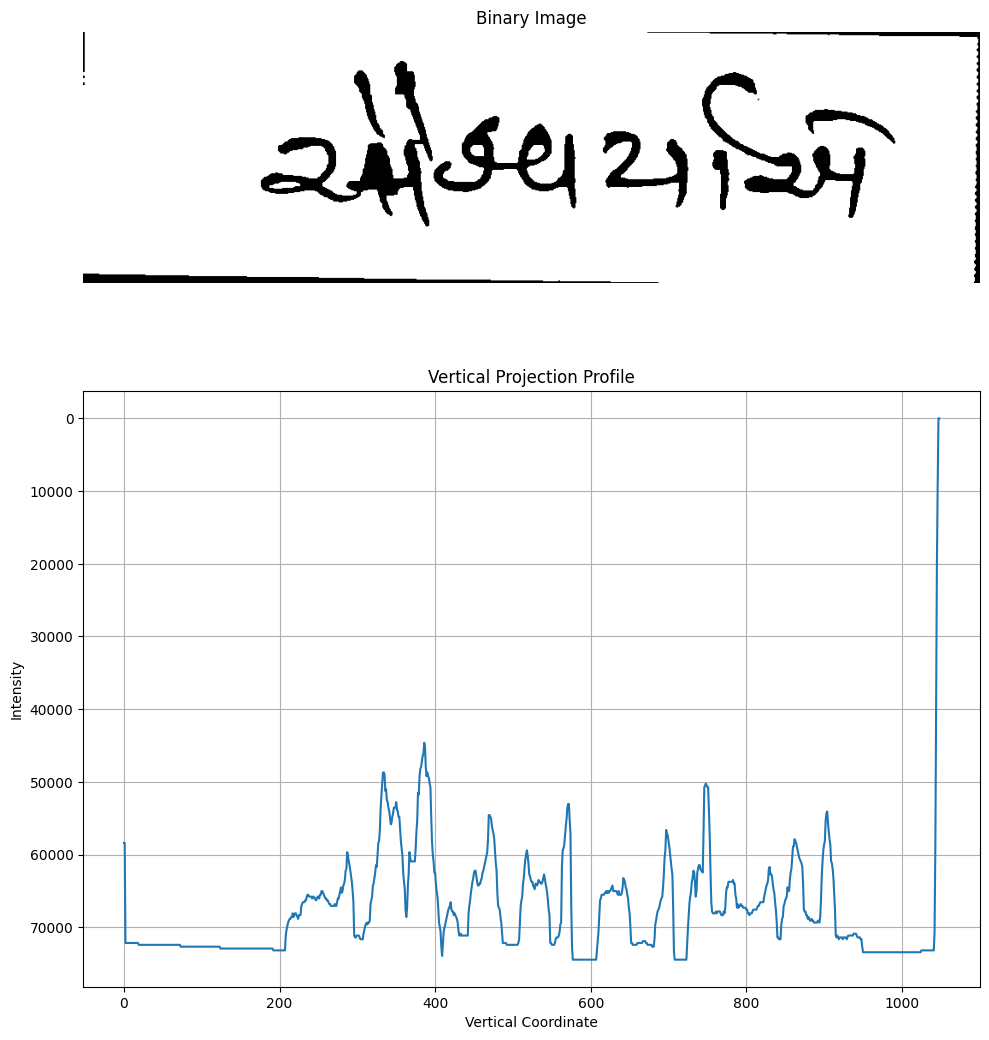

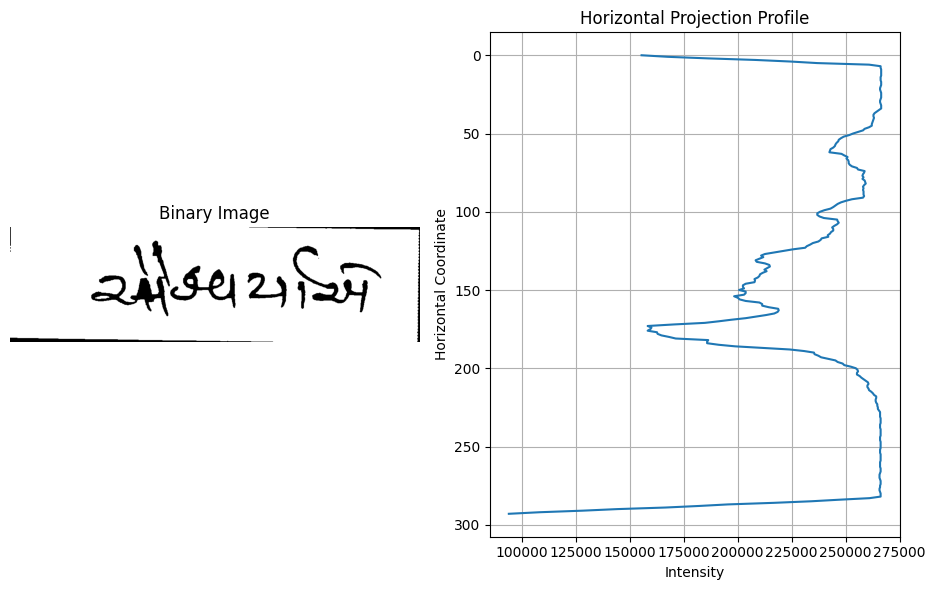

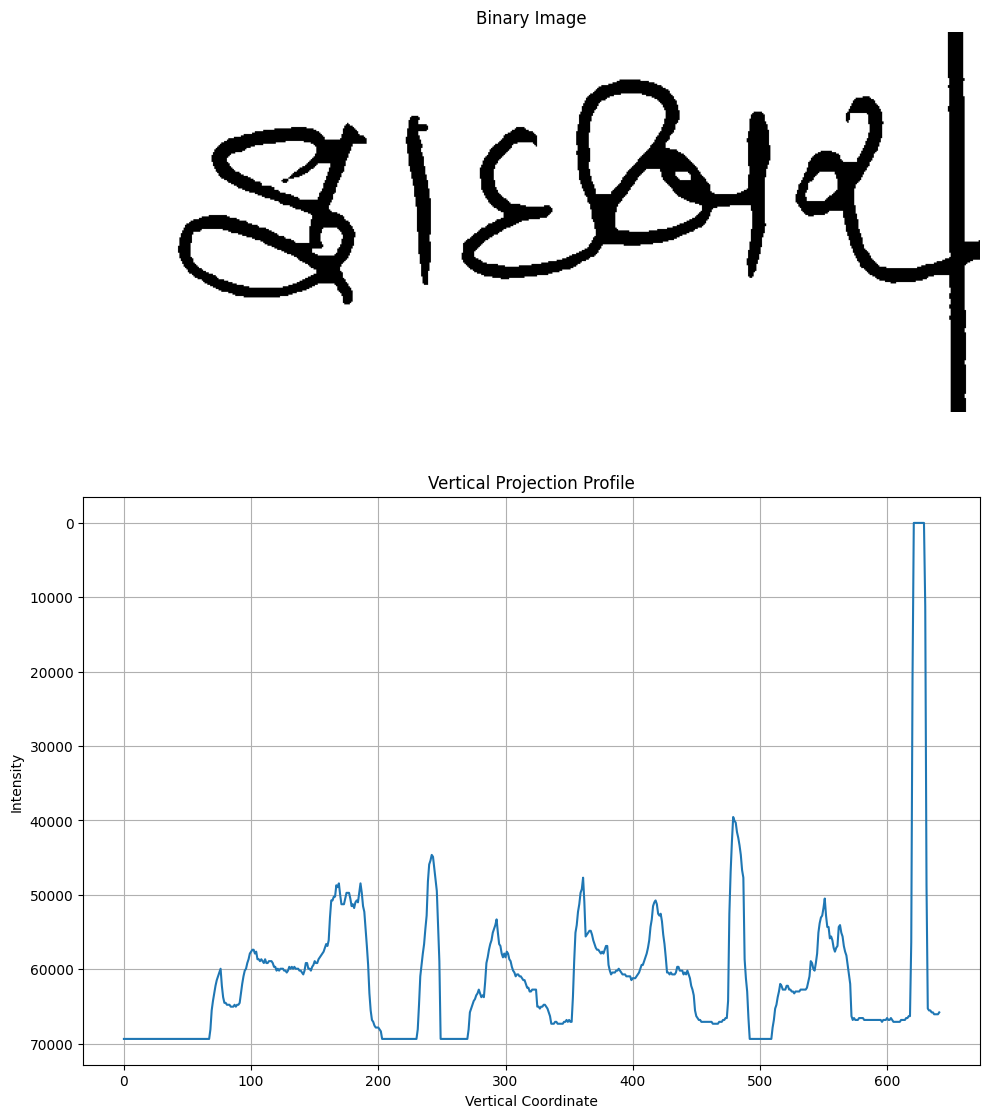

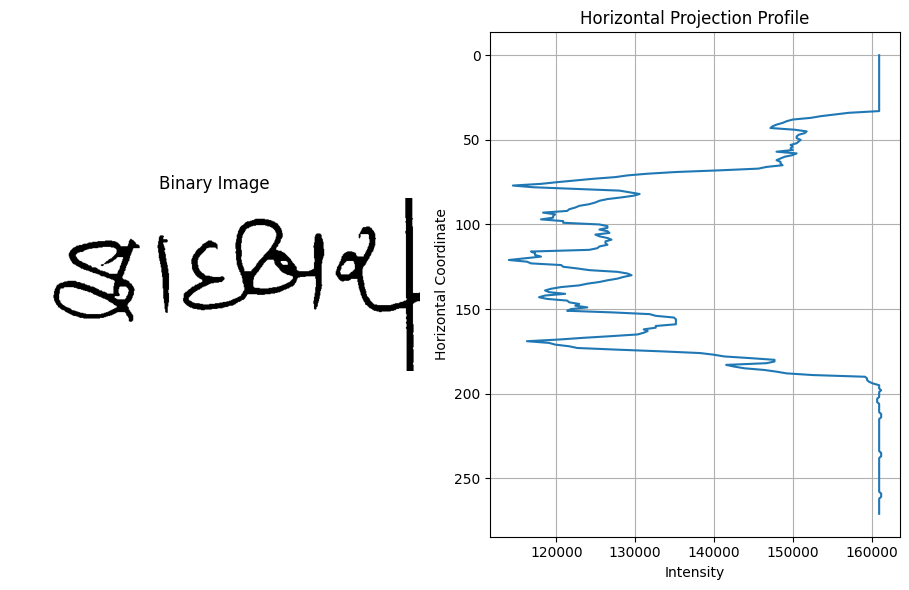

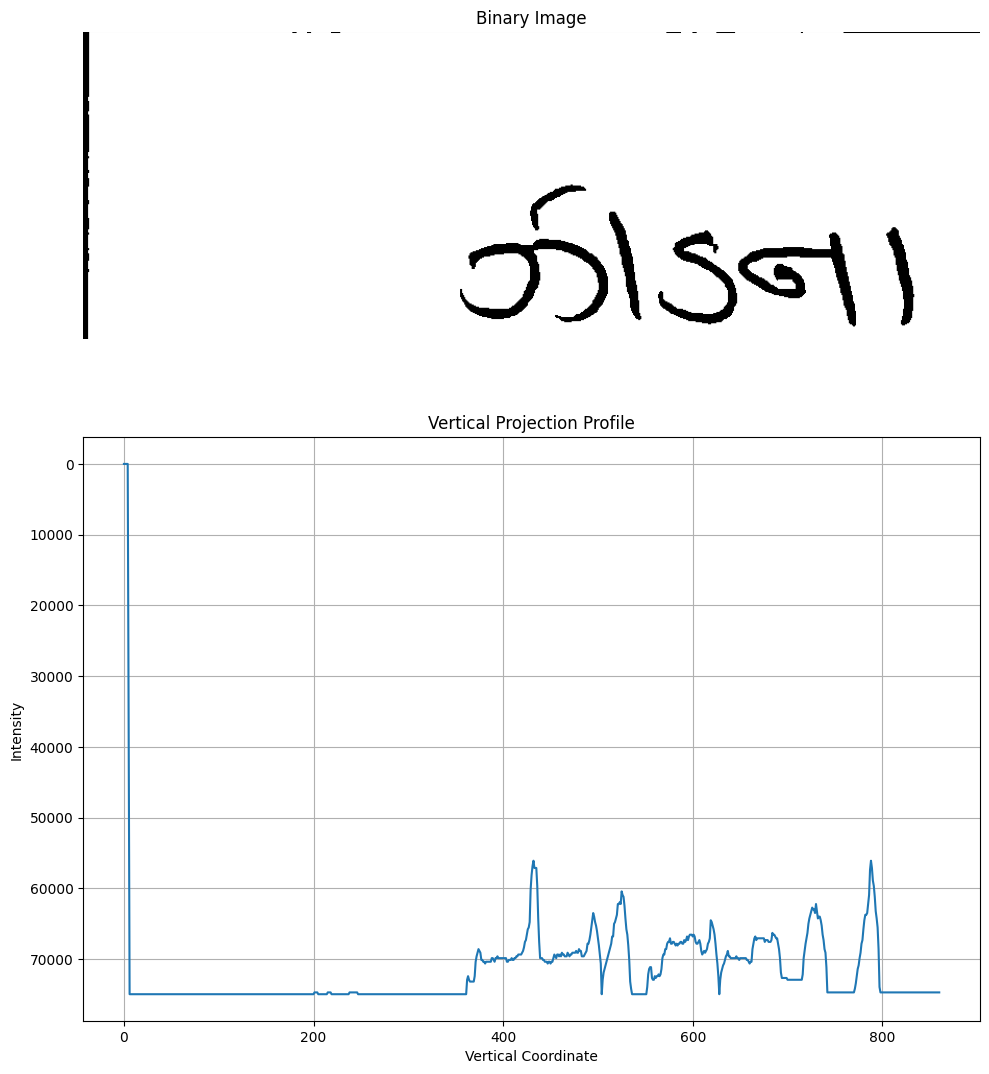

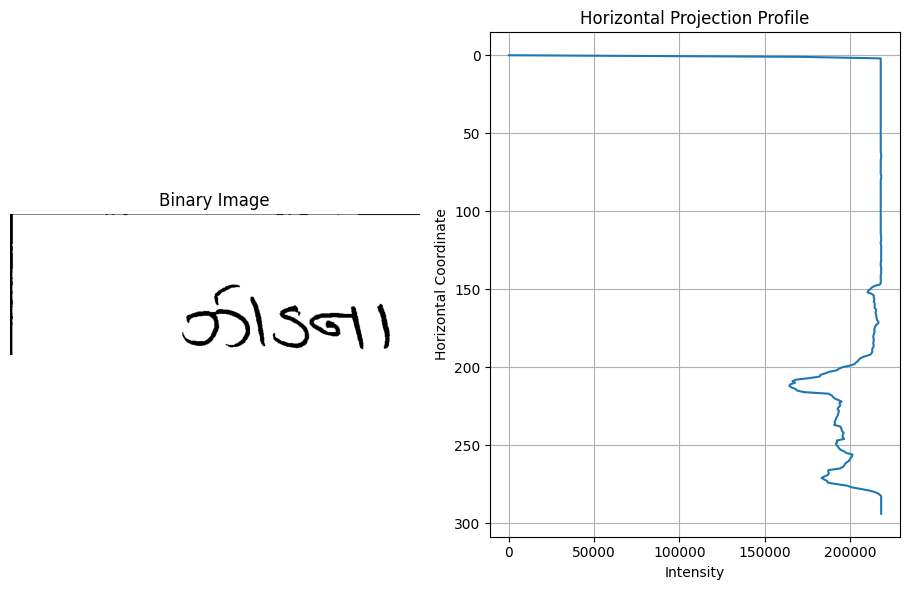

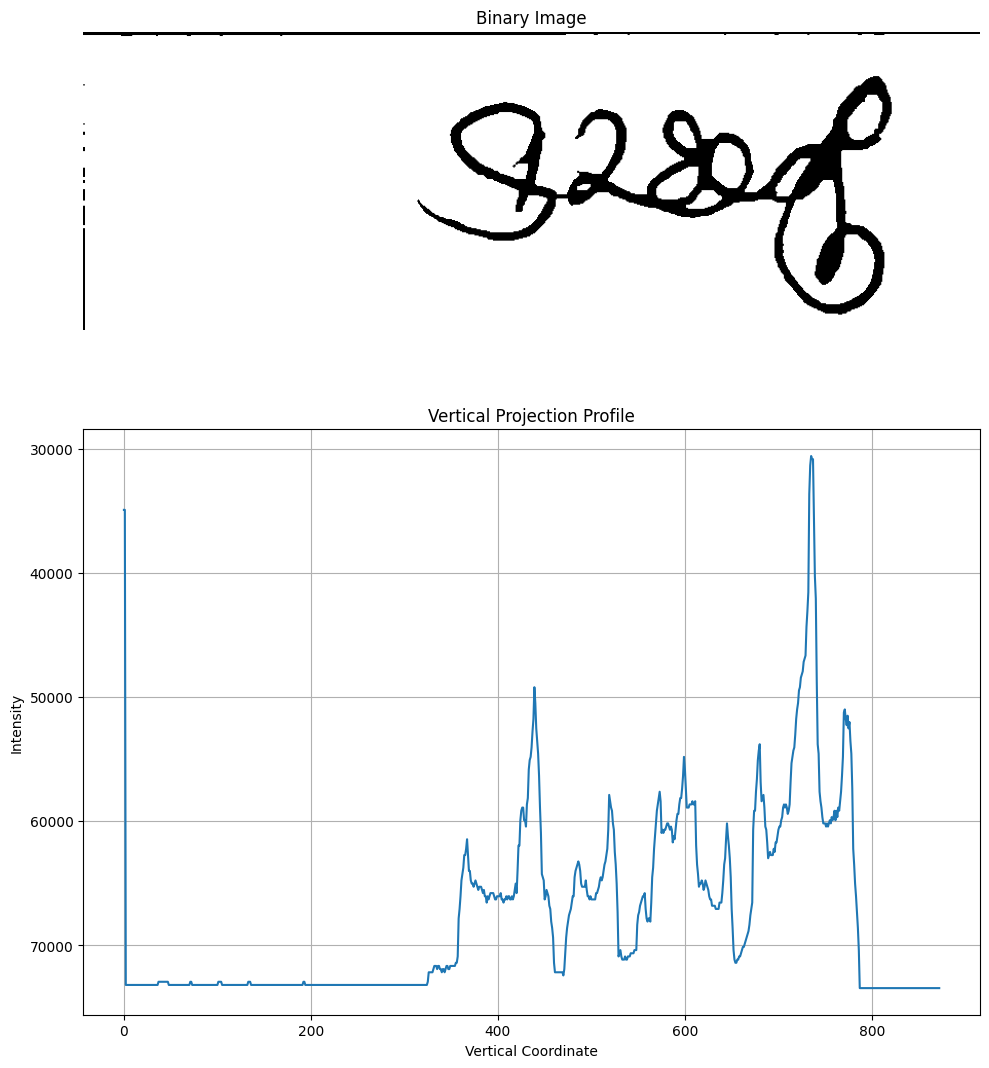

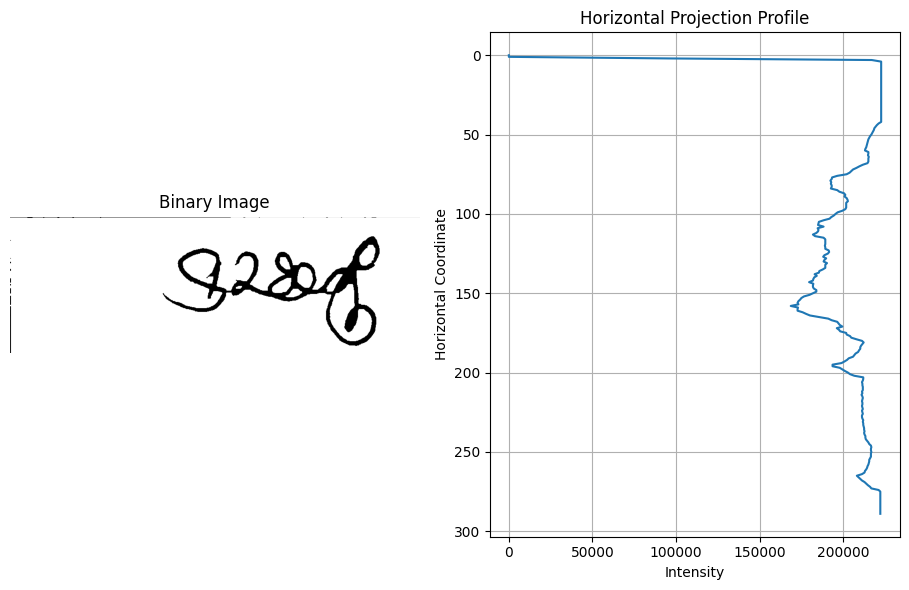

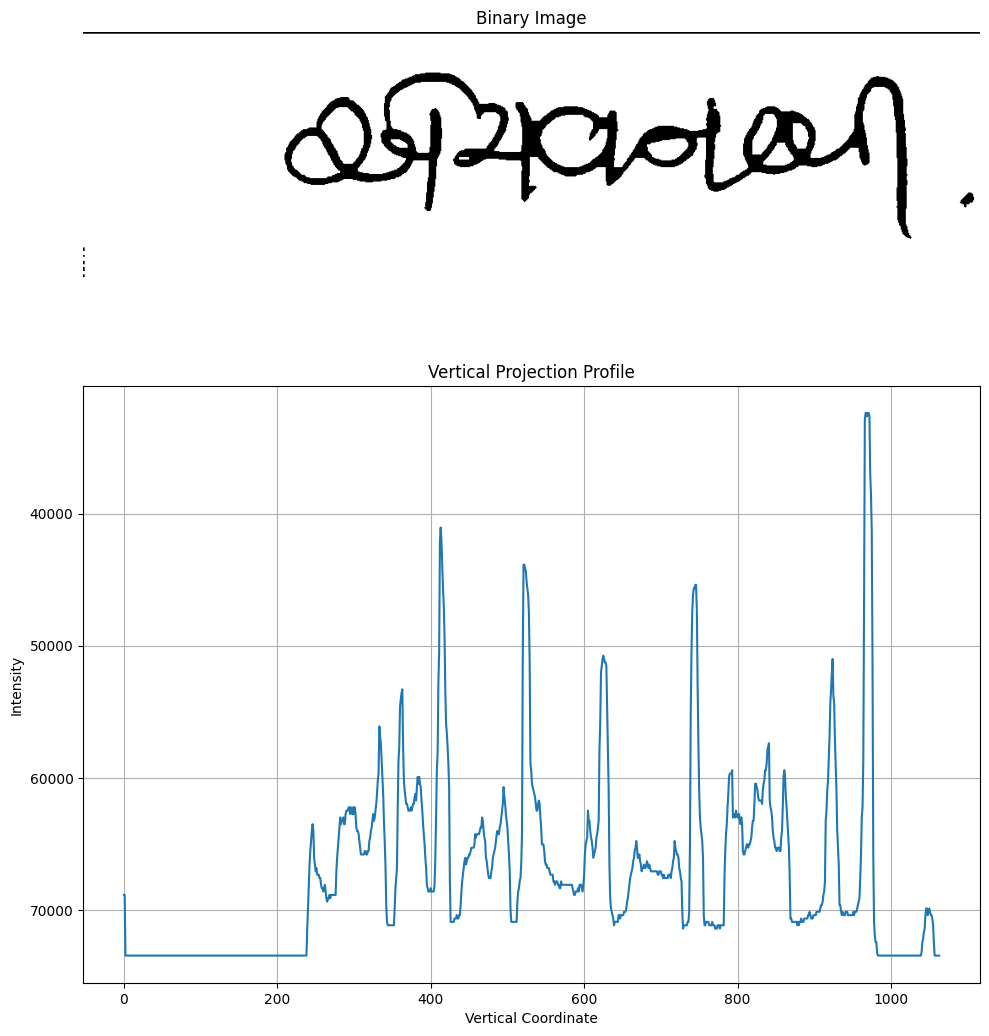

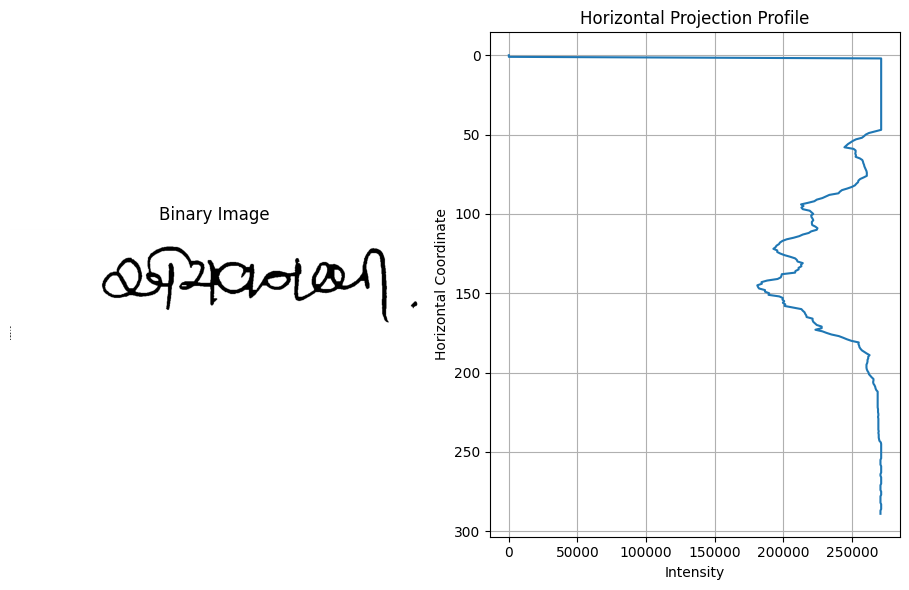

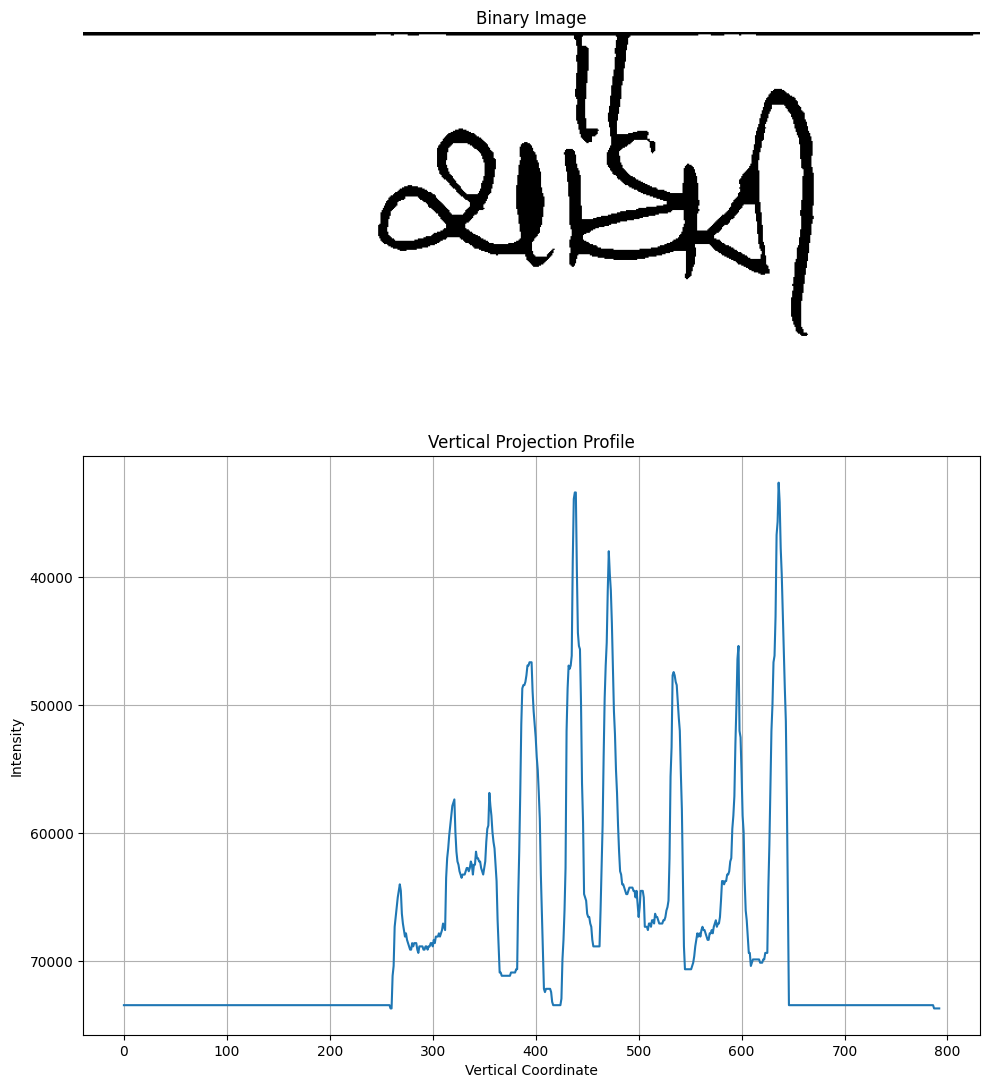

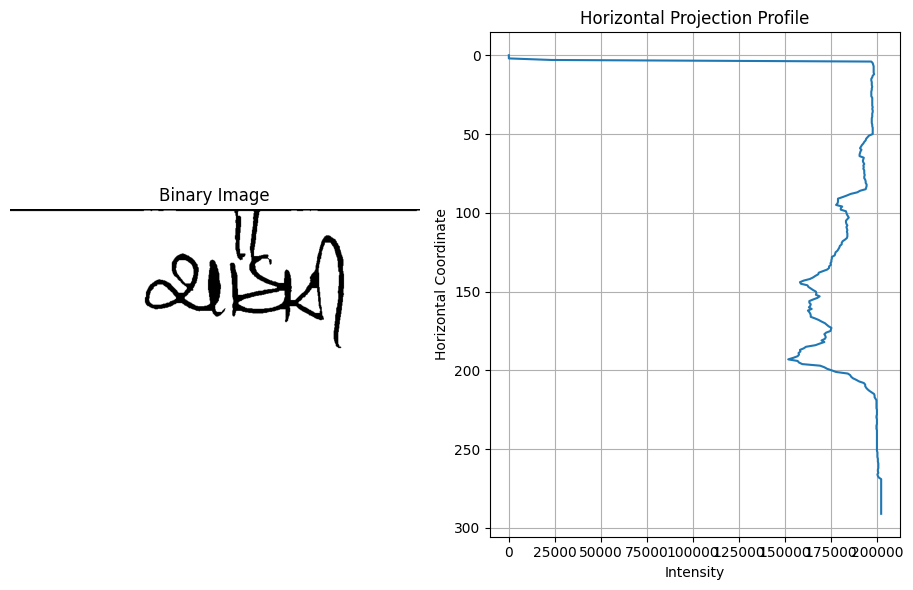

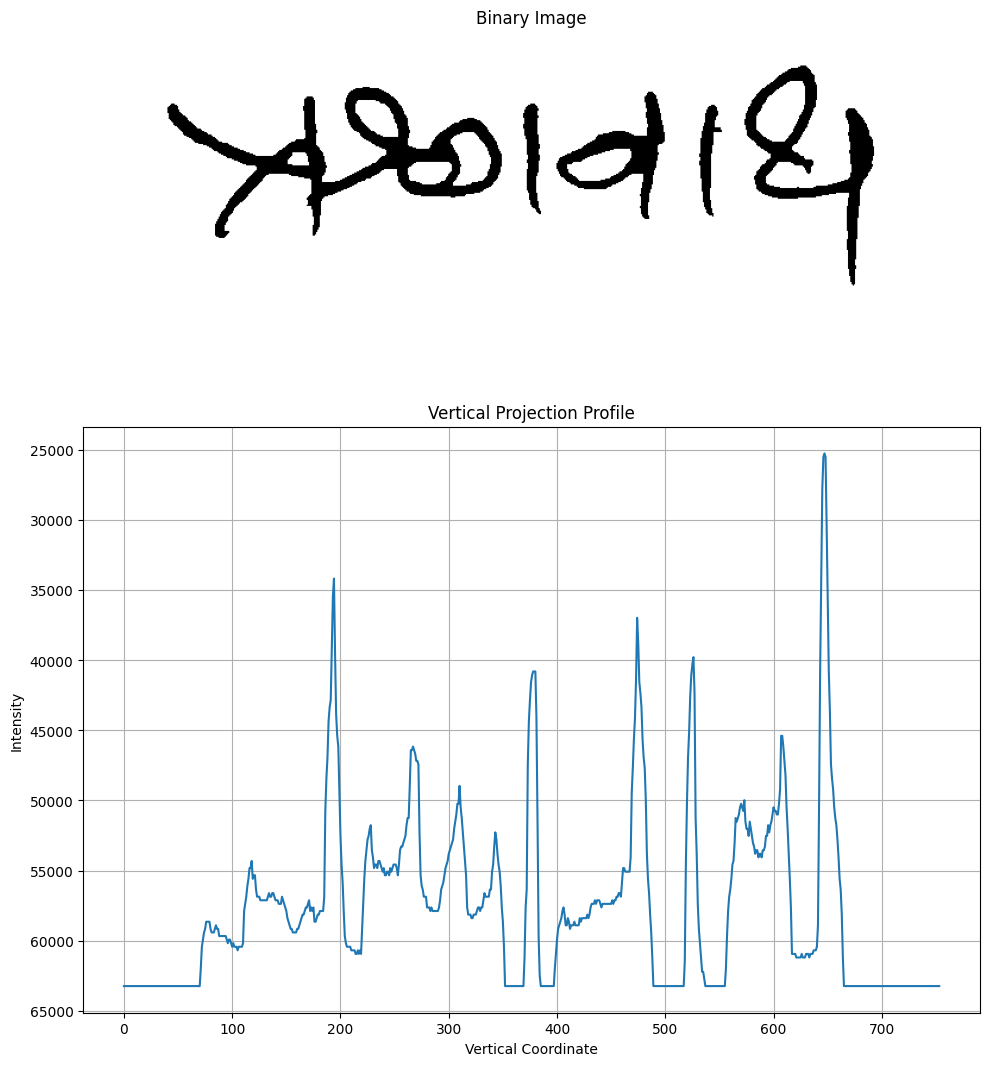

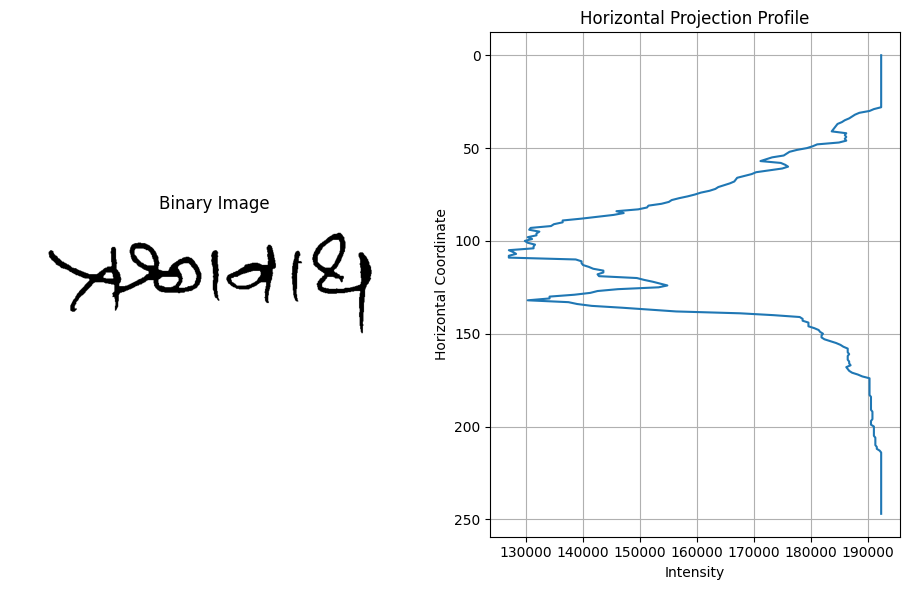

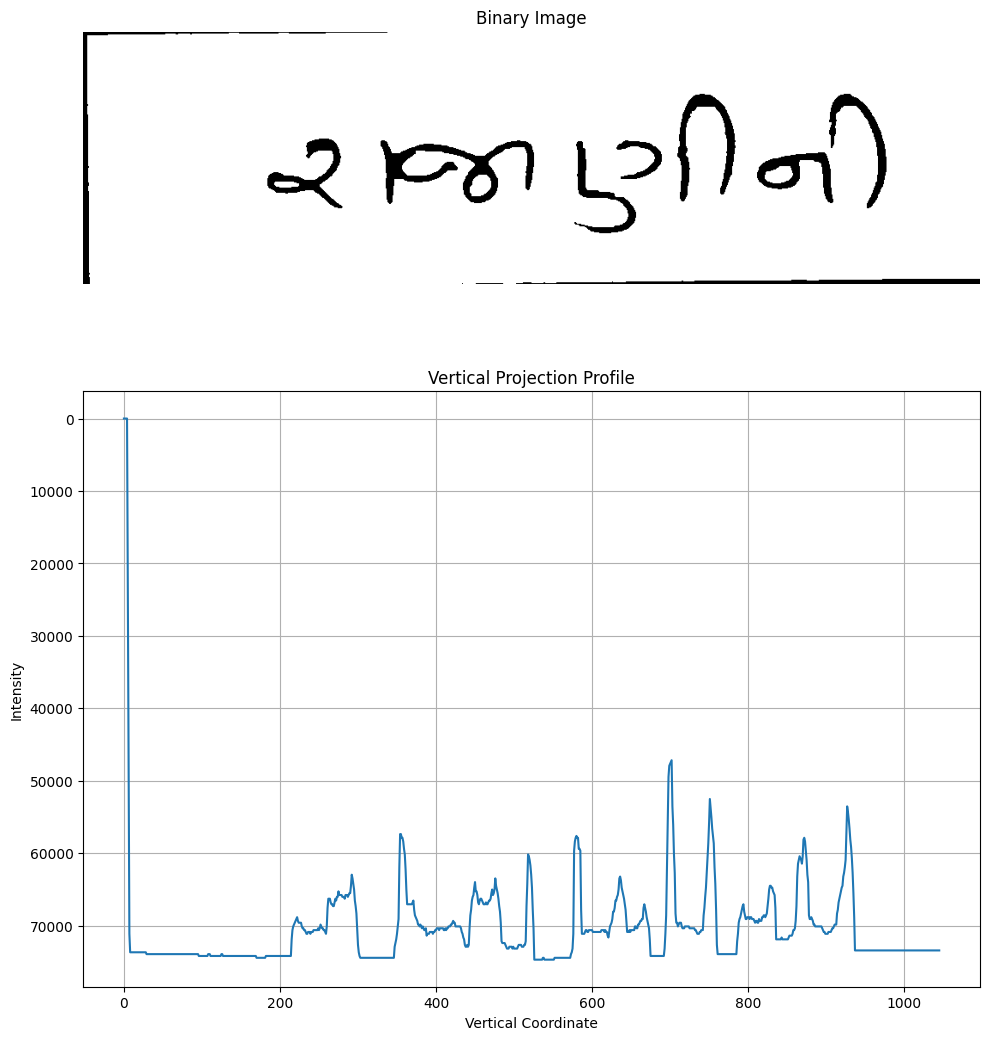

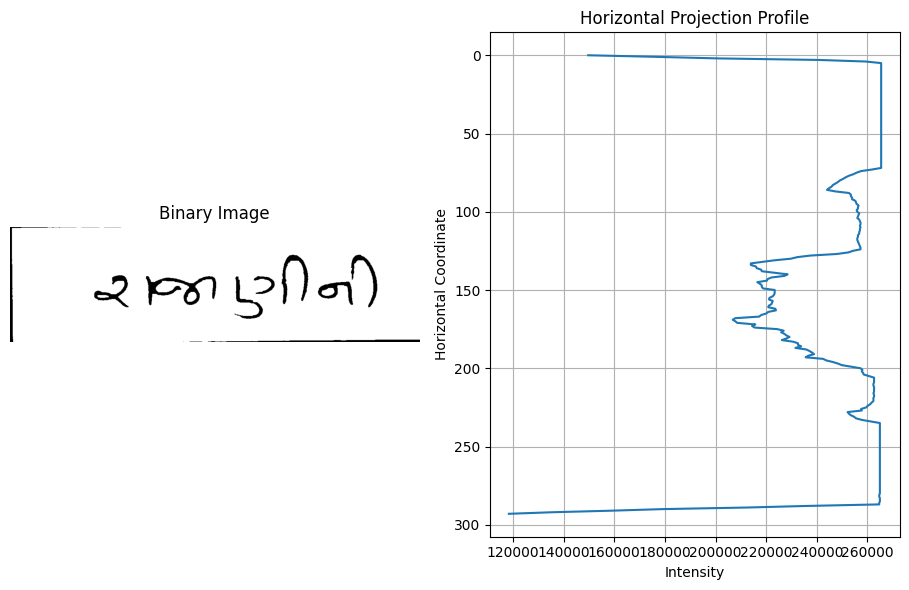

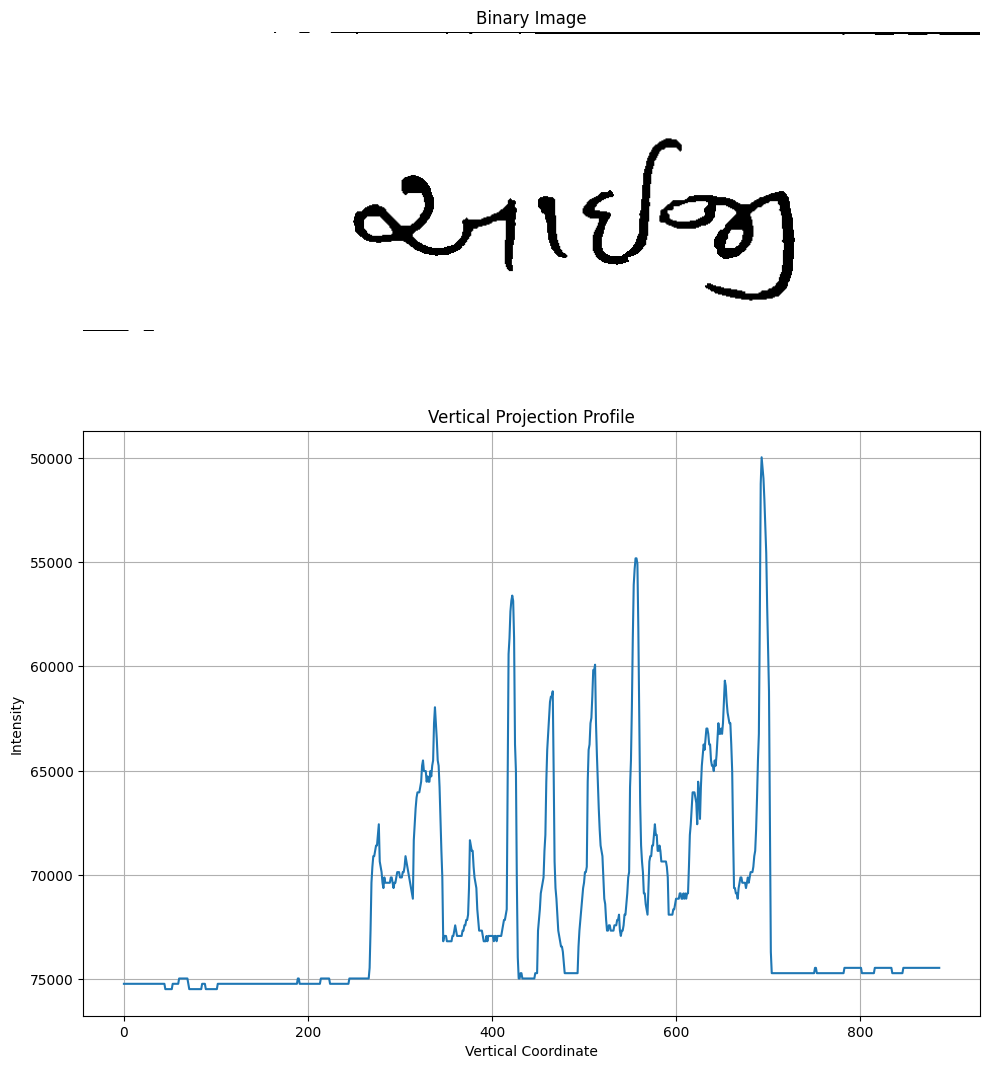

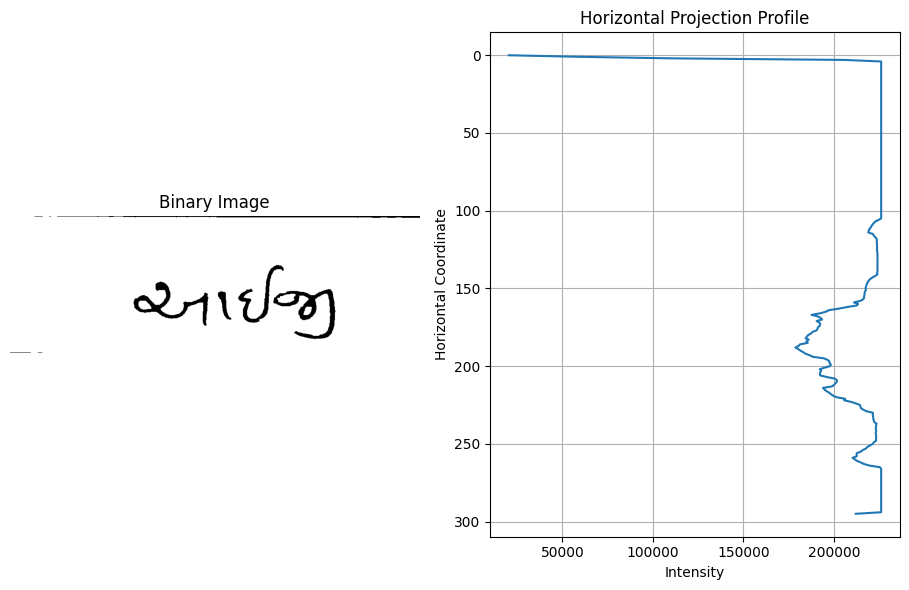

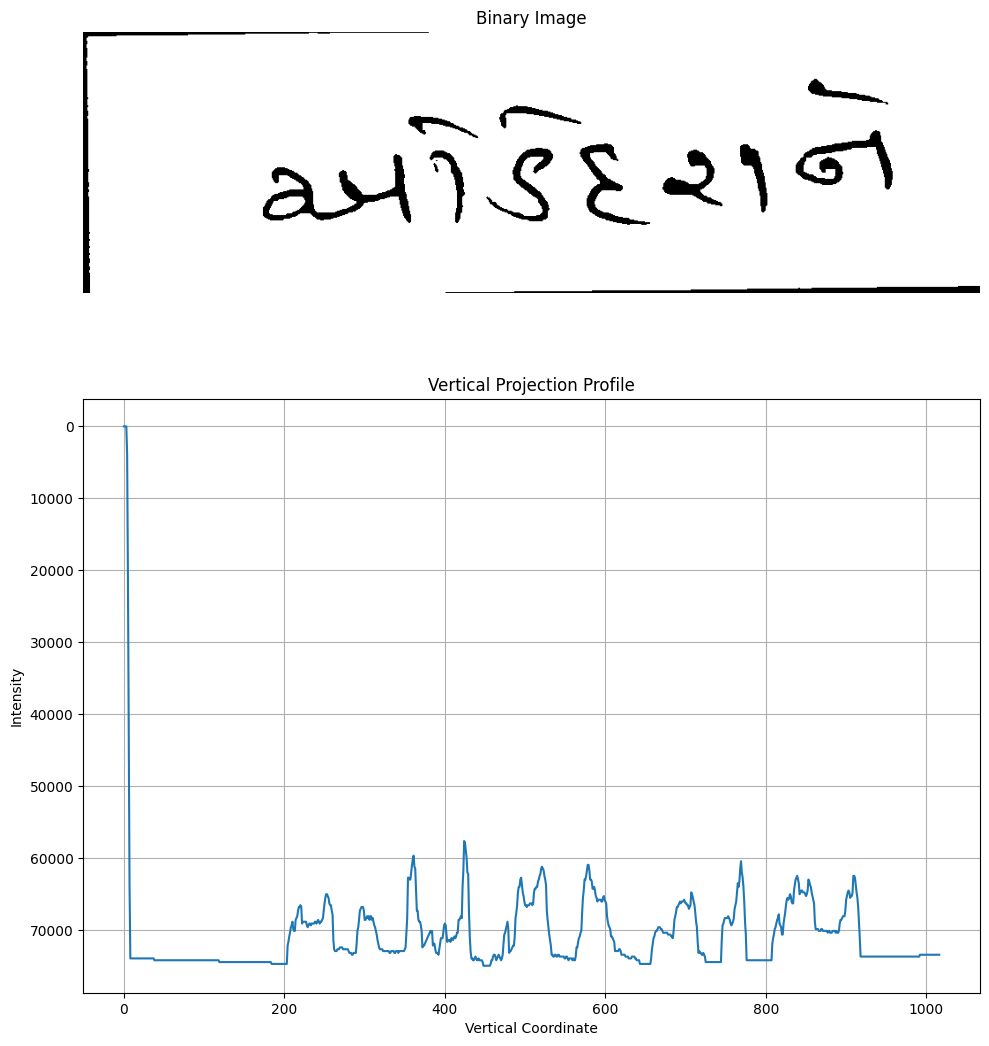

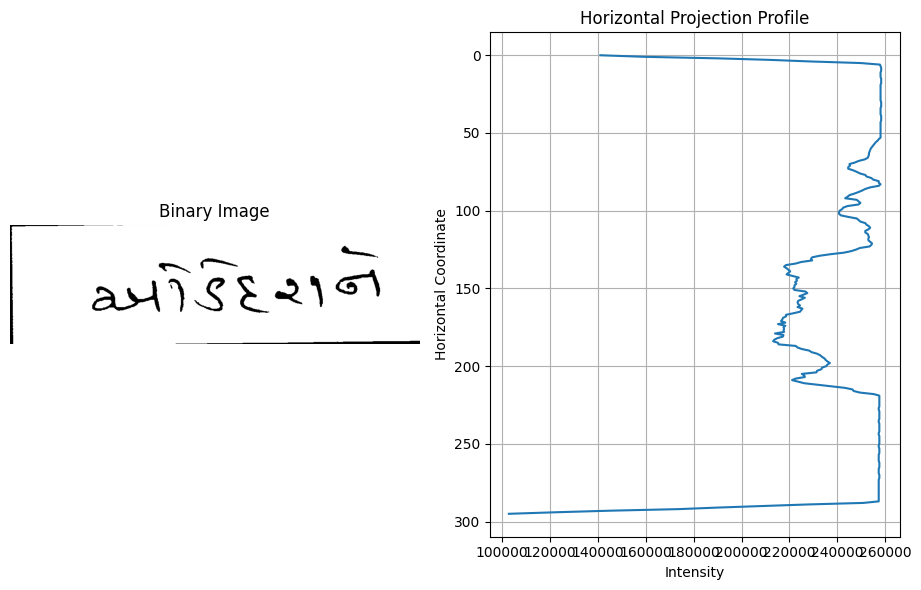

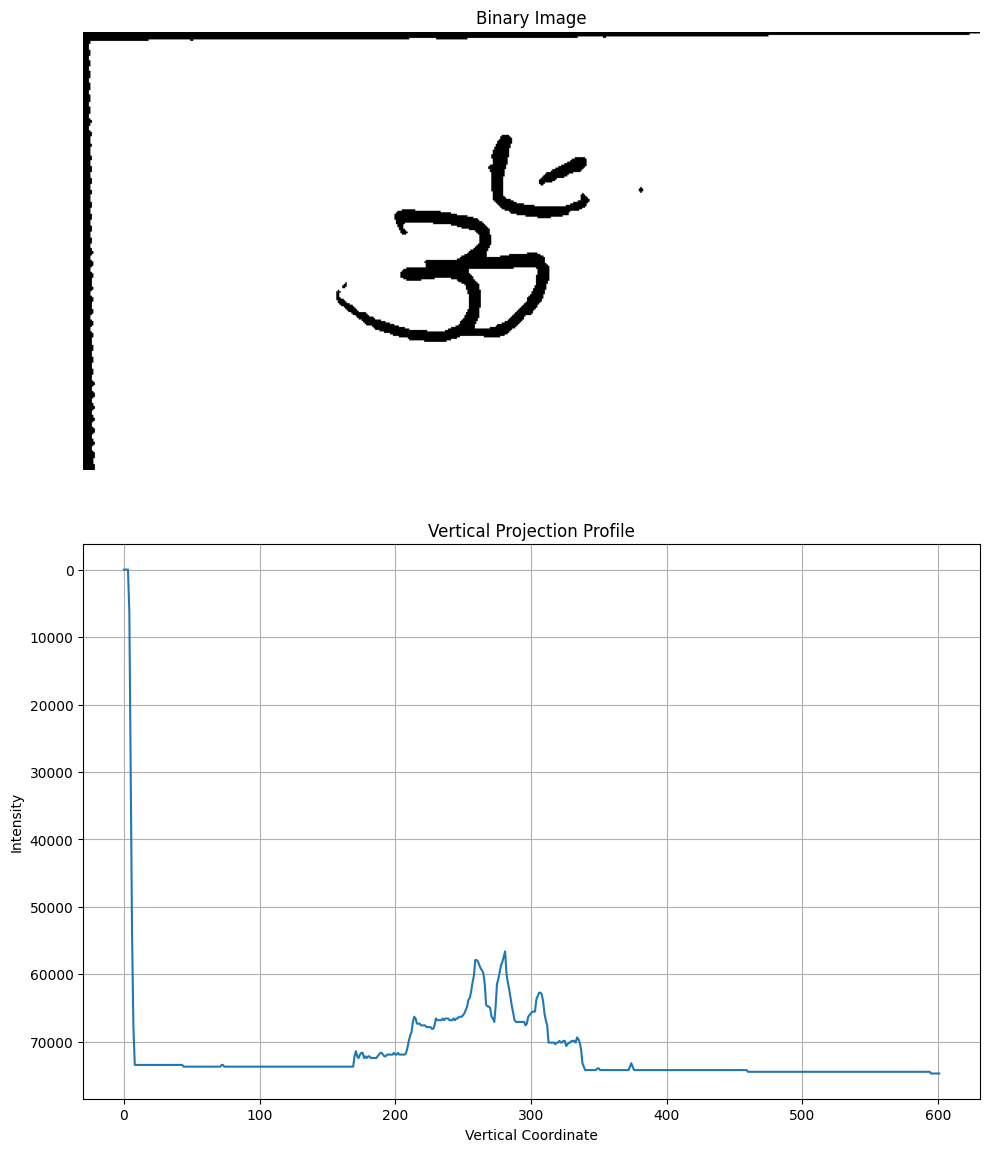

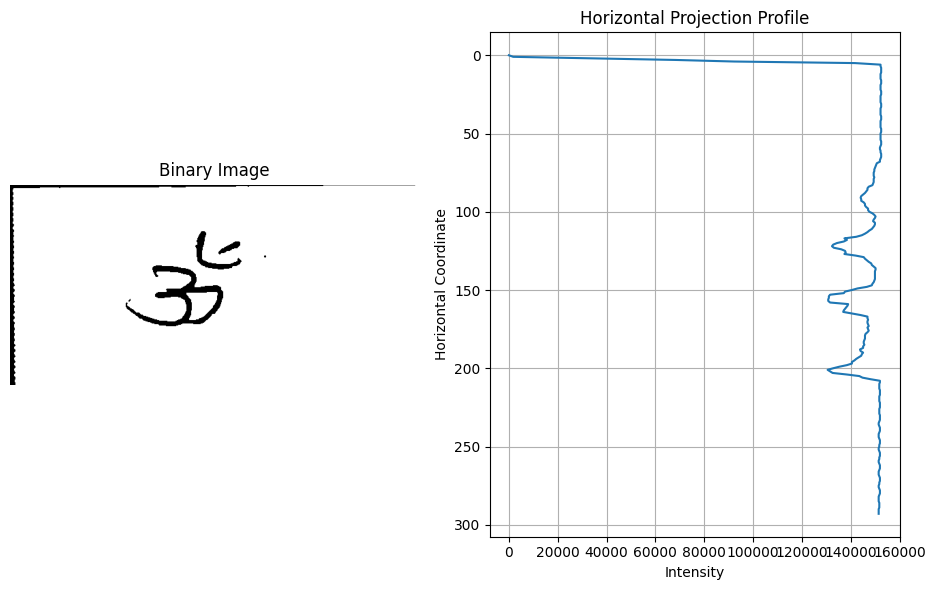

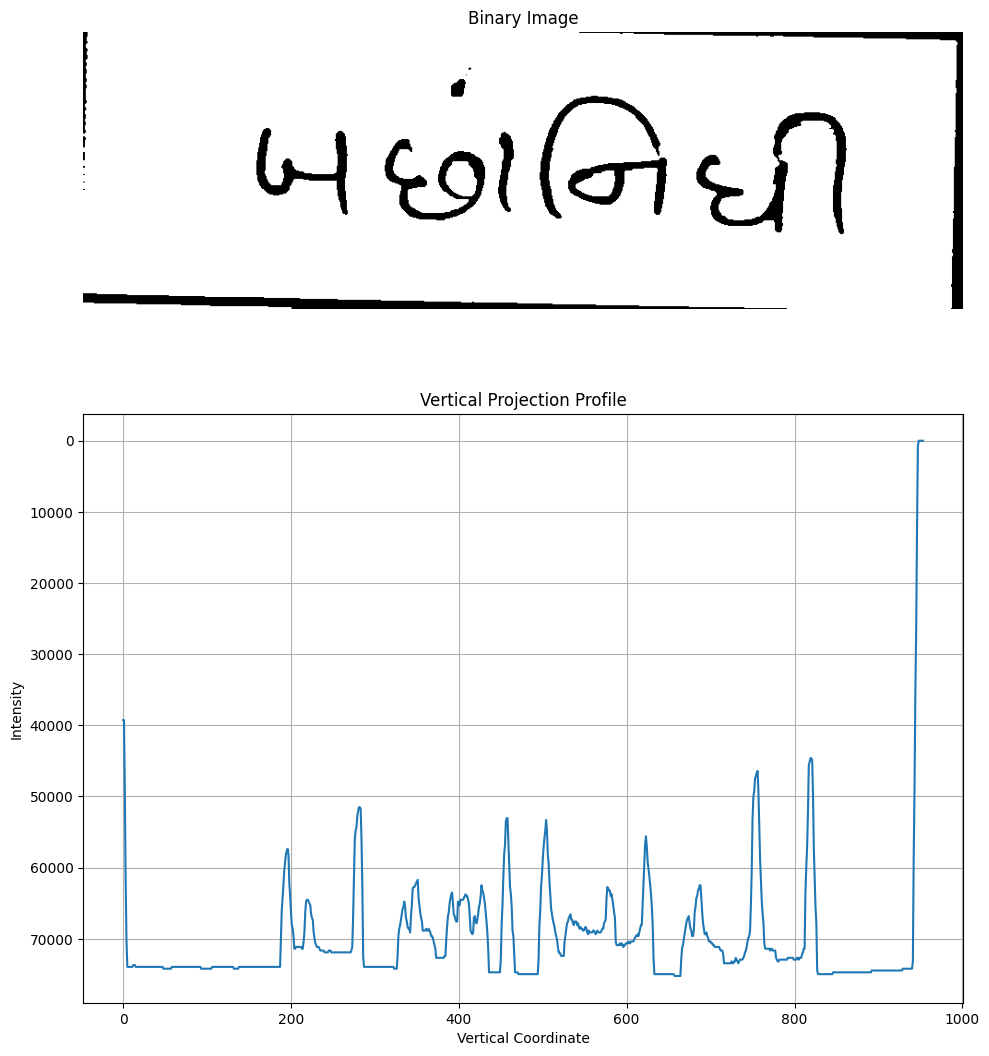

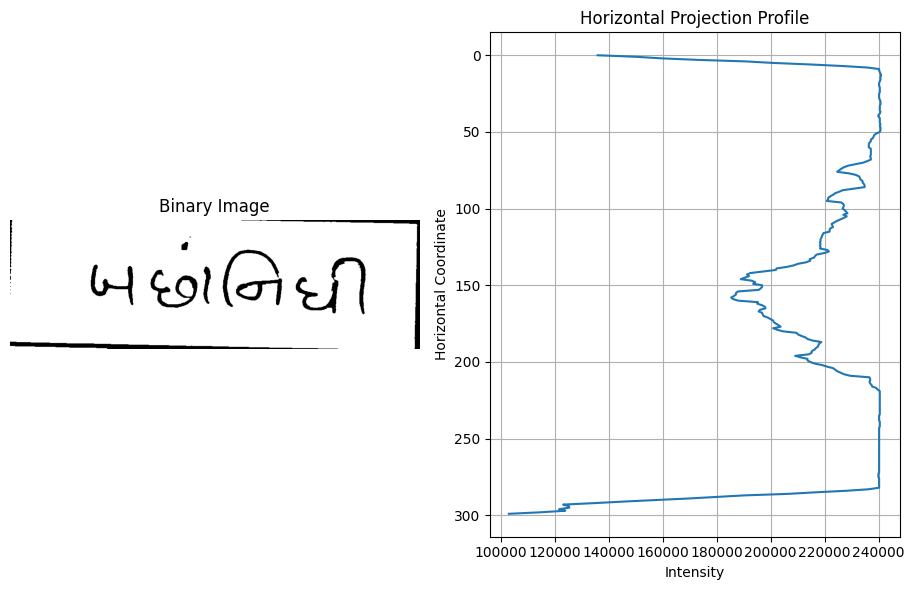

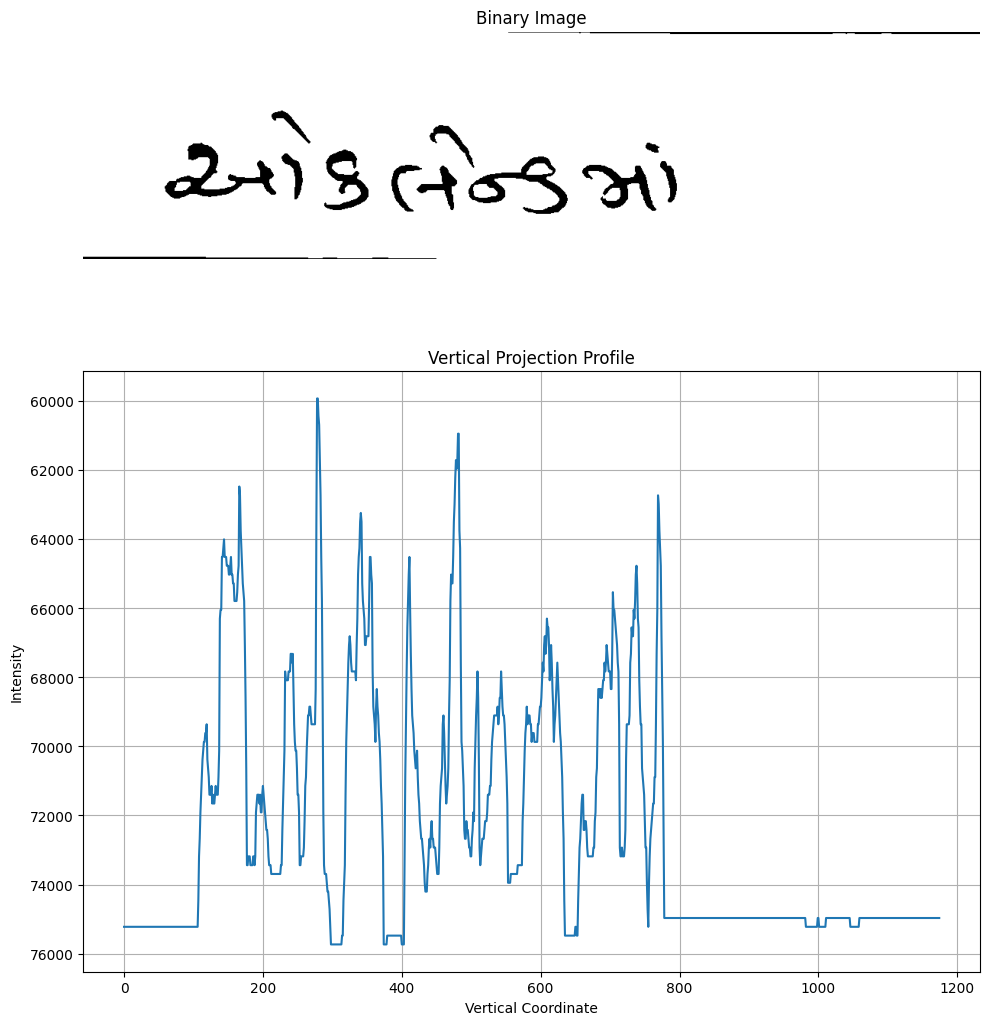

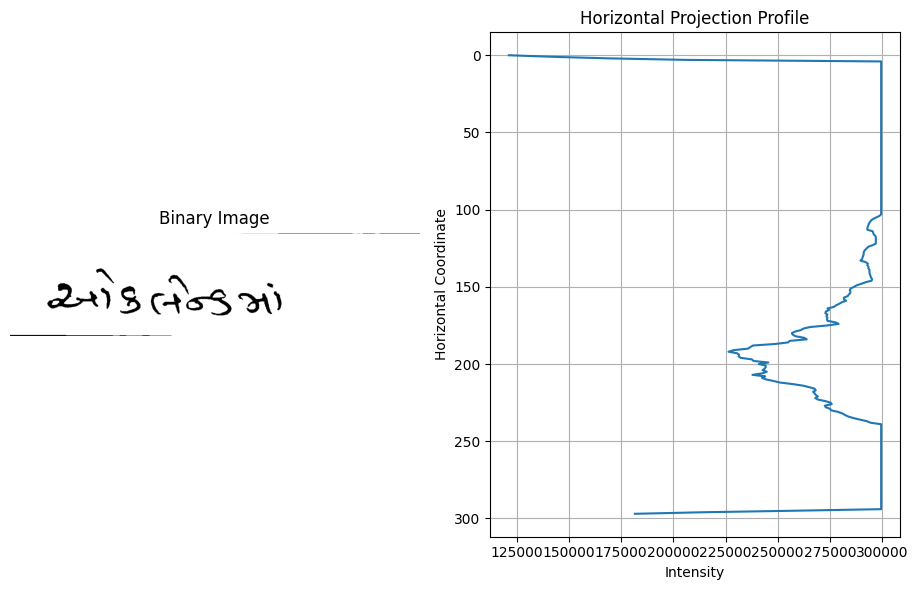

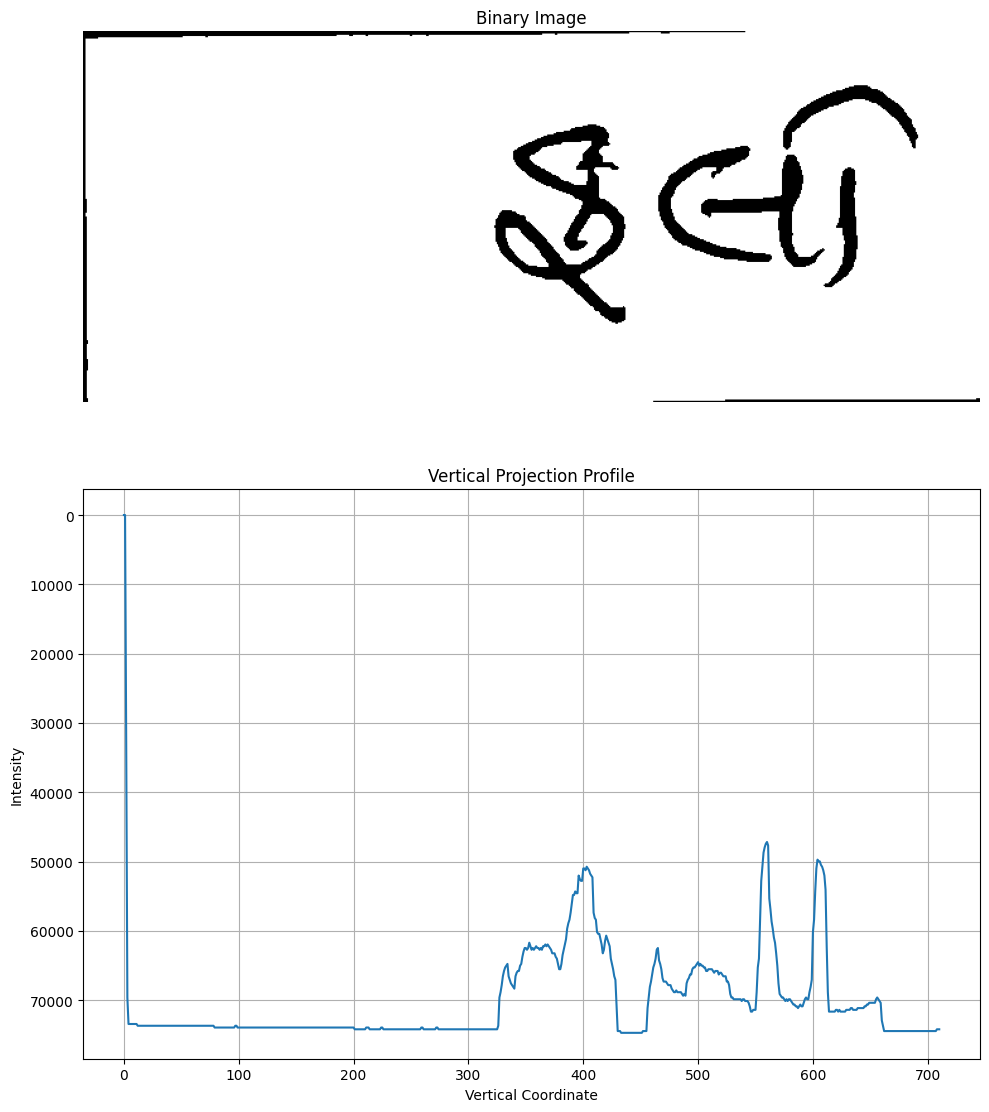

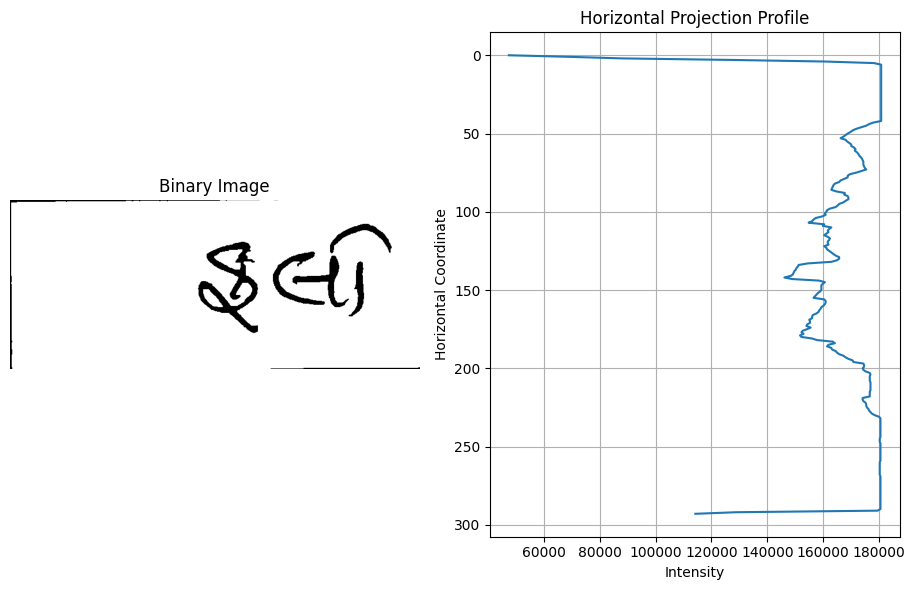

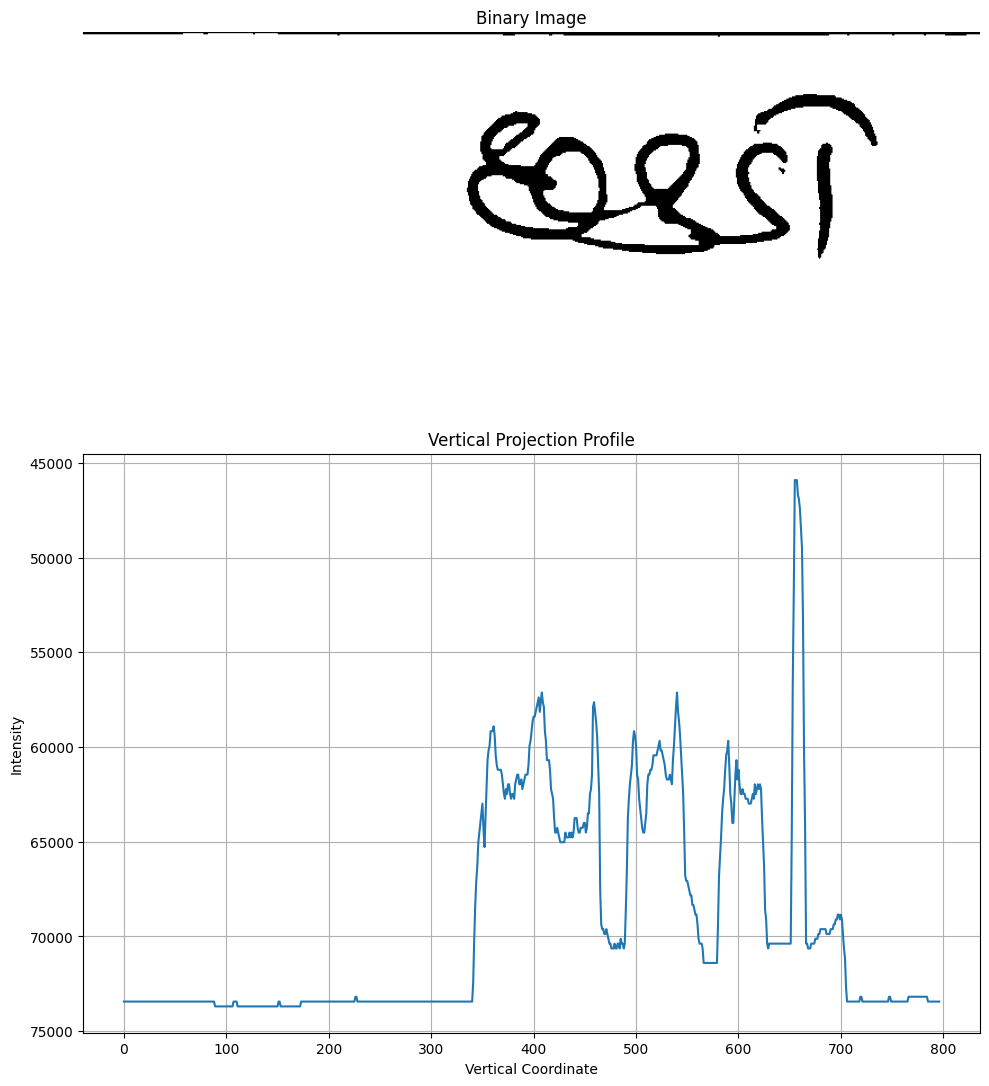

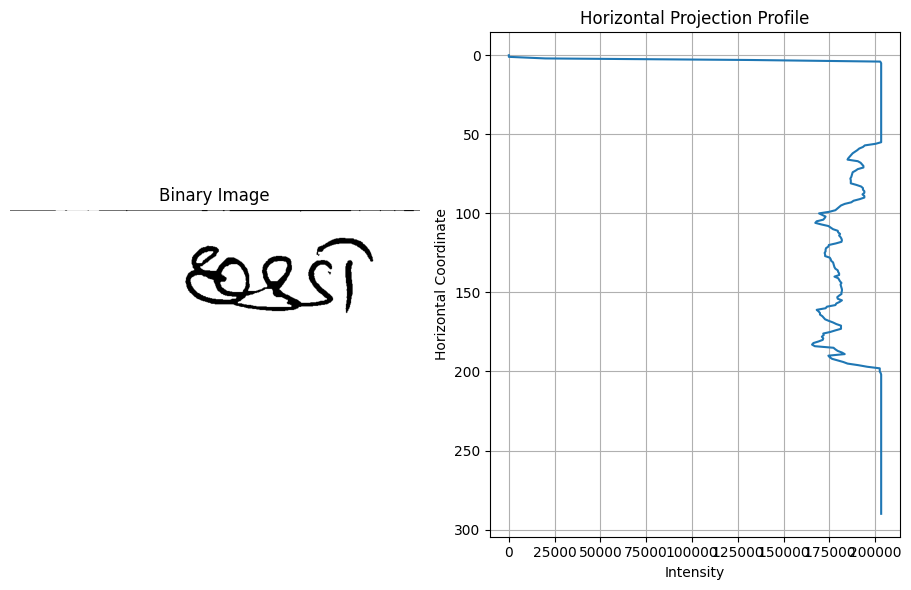

In [32]:
if __name__ == "__main__":
    main()